In [40]:
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing,multioutput
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours,RandomUnderSampler
import seaborn as sb
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint
from sklearn.multioutput import MultiOutputClassifier,ClassifierChain
from multi_imbalance.resampling.mdo import MDO

# loading Data

In [41]:
data = pd.read_csv('LLCP2023.csv',delimiter=',')
pd.set_option('display.max_rows', 500)

data = data[(data['IYEAR'] != 2024)] # REMOVING YEAR 2024


data.shape

(408012, 350)

# Subsetting

In [208]:
Seld = data[['_STATE','_SEX','_RFHLTH','_PHYS14D','_RFBMI5','_TOTINDA','CHOLCHK3',
             'BPHIGH6','EDUCA','CVDSTRK3','CVDCRHD4','CHCSCNC1',
                     '_MENT14D','_RACEPRV', '_RFSMOK3','TOLDHI3','CHOLMED3',
                  'DIABETE4','_AGE_G','_RFBING6','INSULIN1','DIABEDU1','FEETSORE','PREDIAB2']].copy()




Seld = Seld[~Seld['DIABETE4'].isin([7, 9, 2])]



Seld.loc[(Seld['DIABETE4'].isin([3,4])) & (Seld['INSULIN1'].isna()),
                           'INSULIN1'] = 9
Seld.loc[(Seld['DIABETE4'].isin([3,4])) & (Seld['DIABEDU1'].isna()),
                           'DIABEDU1'] = 9

Seld.loc[(Seld['CHOLCHK3'].isin([1])) & (Seld['TOLDHI3'].isna()),
                            'TOLDHI3'] = 9
#Seld.loc[(Seld['CHOLCHK3'].isin([7])) & (Seld['TOLDHI3'].isna()),
 #                          'TOLDHI3'] = 9
Seld.loc[(Seld['CHOLCHK3'].isin([1])) & (Seld['CHOLMED3'].isna()),
                           'CHOLMED3'] = 9

Seld.loc[(Seld['TOLDHI3'].isin([2])) & (Seld['CHOLMED3'].isna()),
                            'CHOLMED3'] = 9
Seld.loc[(Seld['TOLDHI3'].isin([9])) & (Seld['CHOLMED3'].isna()),
                             'CHOLMED3'] = 9




Seld = Seld.dropna(subset=['DIABETE4'])



Seld.isnull().sum()    
    
    
#'BLIND','DIFFWALK','CVDCRHD4',,'BPHIGH6','DIABAGE4'

_STATE           0
_SEX             0
_RFHLTH          0
_PHYS14D         0
_RFBMI5          0
_TOTINDA         0
CHOLCHK3         0
BPHIGH6          0
EDUCA            4
CVDSTRK3         1
CVDCRHD4         0
CHCSCNC1         0
_MENT14D         0
_RACEPRV        86
_RFSMOK3         0
TOLDHI3      24637
CHOLMED3     24660
DIABETE4         0
_AGE_G           0
_RFBING6         0
INSULIN1     33594
DIABEDU1     33622
FEETSORE    381343
PREDIAB2    252043
dtype: int64

In [214]:
len(Seld['_STATE'].value_counts())

52

In [216]:
subset = Seld[Seld['_STATE'] == ]
len(subset[subset['DIABETE4'].isna()])


0

# Discriptive analysis

/tmp/ipykernel_613304/3881799905.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Age Group', y='Number of Patients', data=age_counts, palette='viridis', ax=axes[0])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


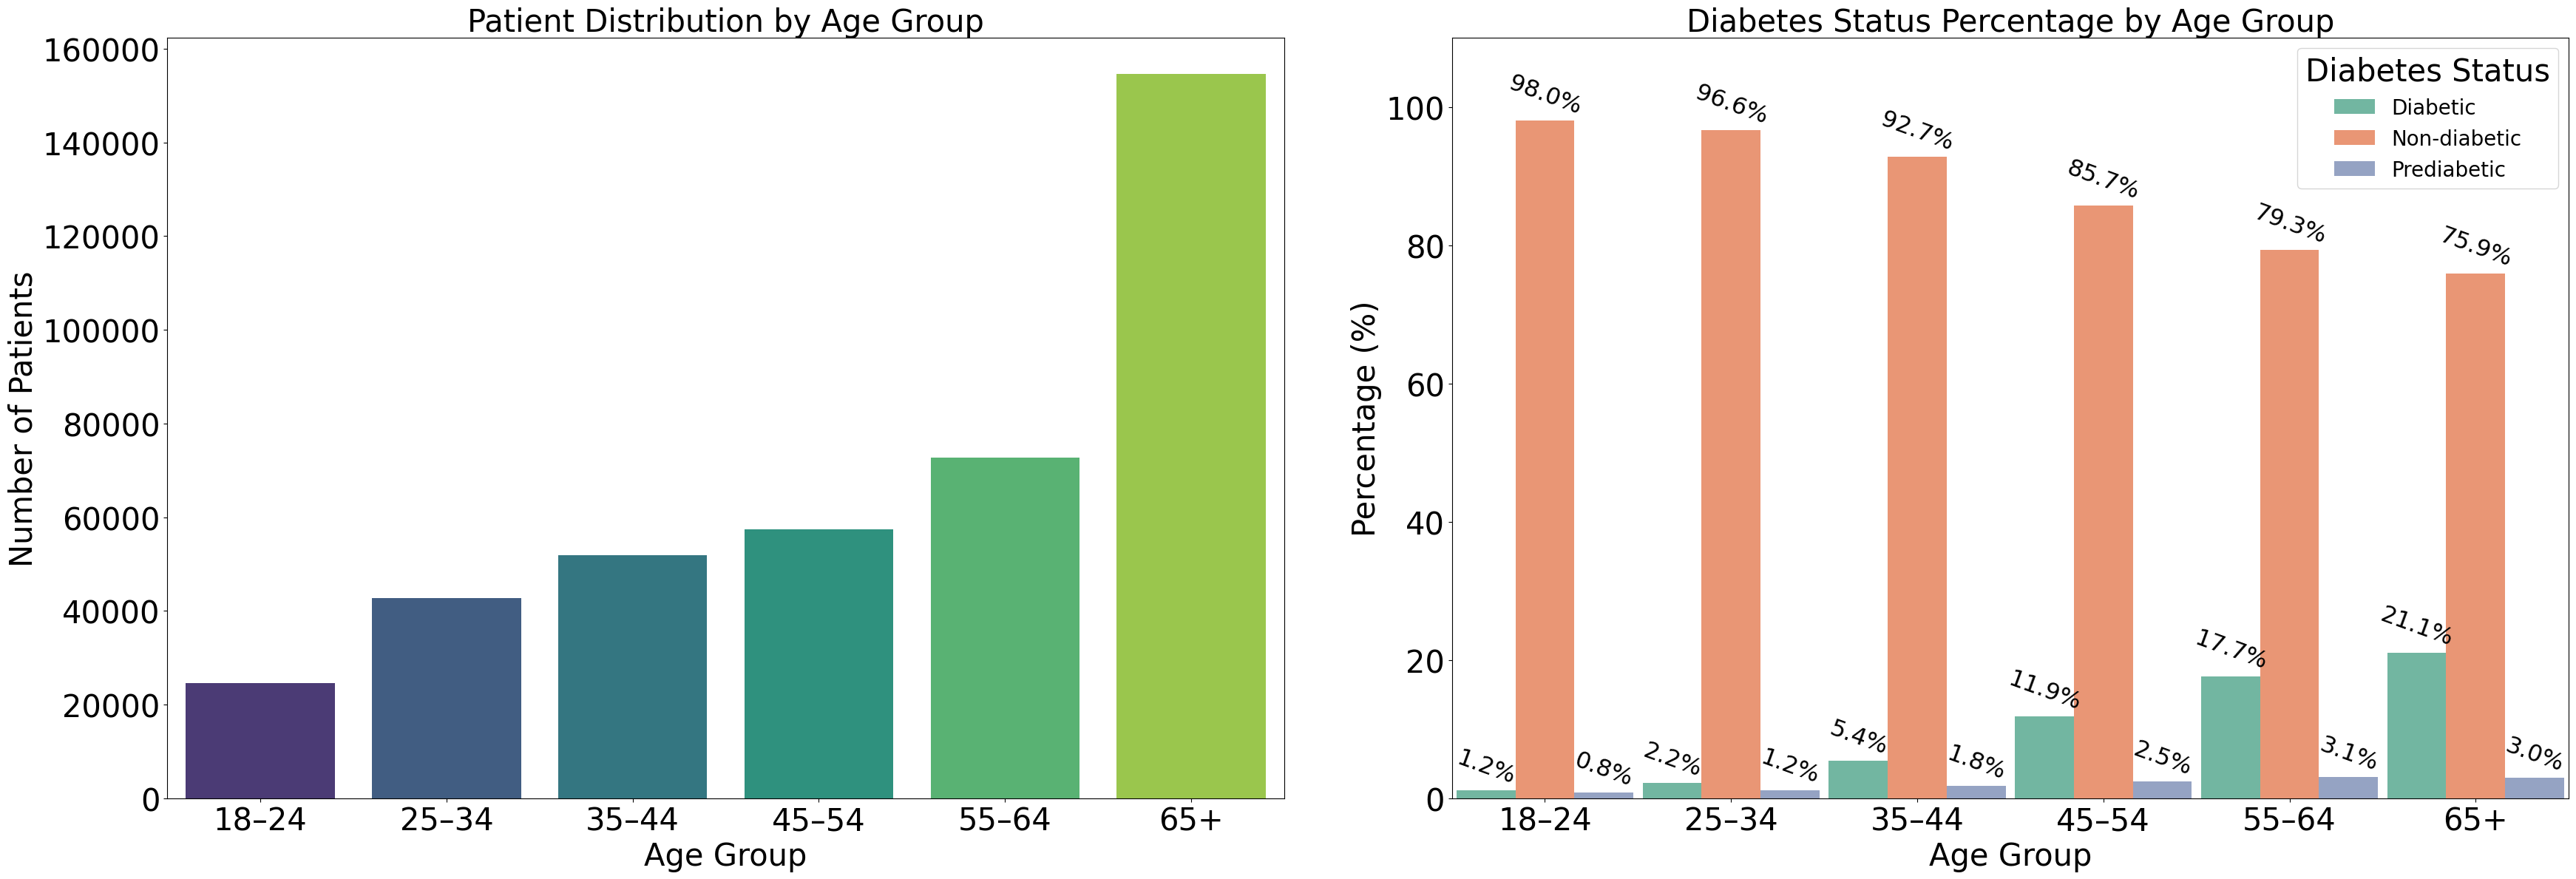

In [285]:
age_labels = {
    1: '18–24',
    2: '25–34',
    3: '35–44',
    4: '45–54',
    5: '55–64',
    6: '65+'
}

diab_labels = {
    1: 'Diabetic',
    3: 'Non-diabetic',
    4: 'Prediabetic',
}

# Apply labels
Seld['age_group_label'] = Seld['_AGE_G'].map(age_labels)
Seld['diab_group_label'] = Seld['DIABETE4'].map(diab_labels)

                                                                      
filtered = Seld.dropna(subset=['age_group_label', 'diab_group_label']) # Drop rows with missing labels

# Grouping and calculating percentage
grouped = (
    filtered.groupby(['age_group_label', 'diab_group_label'])
    .size()
    .reset_index(name='count')
)

totals = grouped.groupby('age_group_label')['count'].transform('sum')
grouped['percentage'] = 100 * grouped['count'] / totals

# Calculate total counts per age group
age_counts = (
    filtered['age_group_label']
    .value_counts()
    .reindex(age_labels.values())
    .reset_index()
)
age_counts.columns = ['Age Group', 'Number of Patients']
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(35, 12))

# Absolute counts
sb.barplot(x='Age Group', y='Number of Patients', data=age_counts, palette='viridis', ax=axes[0])
axes[0].set_title('Patient Distribution by Age Group', fontsize=30)
axes[0].set_xlabel('Age Group', fontsize=30)
axes[0].set_ylabel('Number of Patients', fontsize=30)
axes[0].tick_params(axis='both', labelsize=30)

#axes[0].set_yticks(fontsize=20)
#Percentage by diabetes status (wider bars)
bar_plot = sb.barplot(
    data=grouped,
    x='age_group_label',
    y='percentage',
    hue='diab_group_label',
    palette='Set2',
    ax=axes[1],
    width=0.95  # wider bars (default is 0.8)
)

axes[1].set_title('Diabetes Status Percentage by Age Group', fontsize=30)
axes[1].set_xlabel('Age Group', fontsize=30)
axes[1].set_ylabel('Percentage (%)', fontsize=30)
axes[1].set_ylim(0, 110)
axes[1].legend(title='Diabetes Status',  loc='upper right', fontsize=20, title_fontsize=30)
axes[1].tick_params(axis='both', labelsize=13)

# Annotate bars with percentage labels
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', padding=2, rotation=340, fontsize=23)
    
#fig.figsize= (25,7)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.savefig("my_plot.eps", format="eps")
plt.show()



In [235]:
# Absolute counts
sb.barplot(x='Age Group', y='Number of Patients', data=age_counts, palette='viridis', ax=axes[0])
axes[0].set_title('Patient Distribution by Age Group', fontsize=15)
axes[0].set_xlabel('Age Group', fontsize=15)
axes[0].set_ylabel('Number of Patients', fontsize=15)
axes[0].tick_params(axis='both', labelsize=13)


/tmp/ipykernel_613304/4022463664.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Age Group', y='Number of Patients', data=age_counts, palette='viridis', ax=axes[0])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


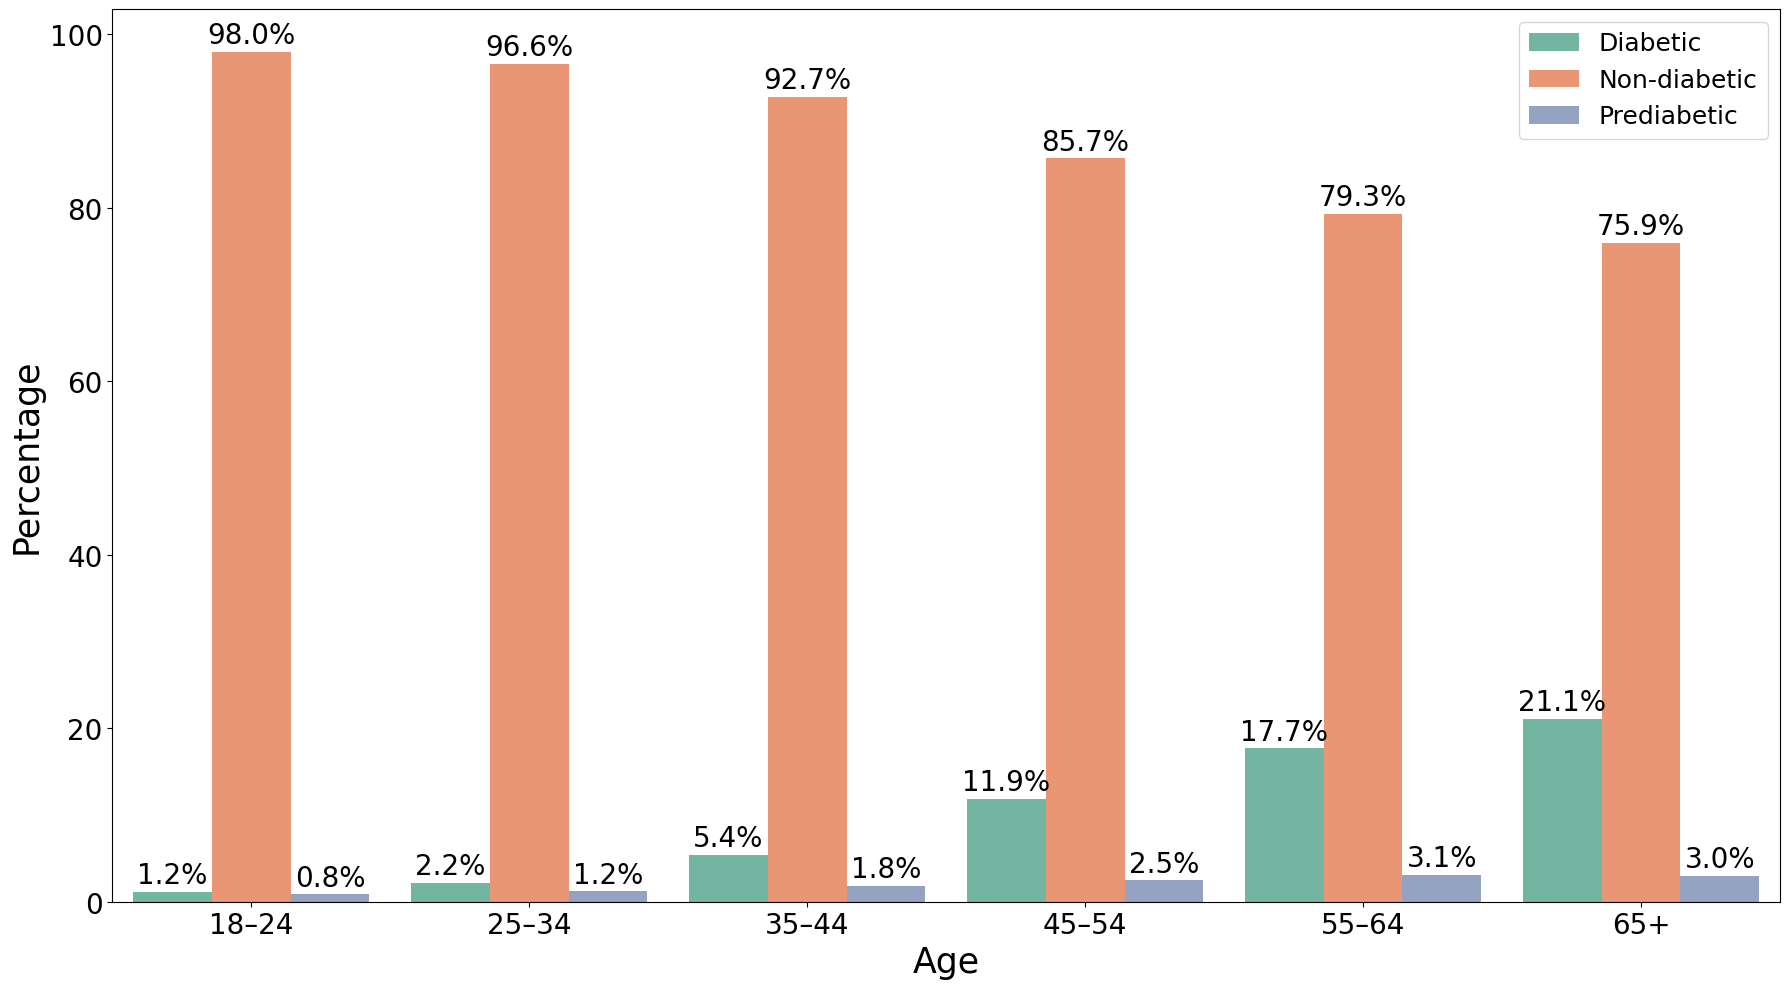

In [252]:
plt.figure(figsize=(18,10))
bar_plot = sb.barplot(
    data=grouped,
    x='age_group_label',
    y='percentage',
    hue='diab_group_label',
    palette='Set2',
    #ax=axes[1],
    width=0.85  # wider bars (default is 0.8)
)

# axes[1].set_title('Diabetes Status Percentage by Age Group', fontsize=15)
# axes[1].set_xlabel('Age Group', fontsize=15)
# axes[1].set_ylabel('Percentage (%)', fontsize=15)
# axes[1].set_ylim(0, 105)
# axes[1].legend(title='Diabetes Status', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15, title_fontsize=15)
# axes[1].tick_params(axis='both', labelsize=13)


for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.1f%%', label_type='edge', padding=2, fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel( 'Age',fontsize= 25)
plt.ylabel('Percentage',fontsize=25)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig("my_plot.eps", format="eps")
plt.legend(fontsize=18)
plt.show()


In [275]:
?bar_plot.bar_label

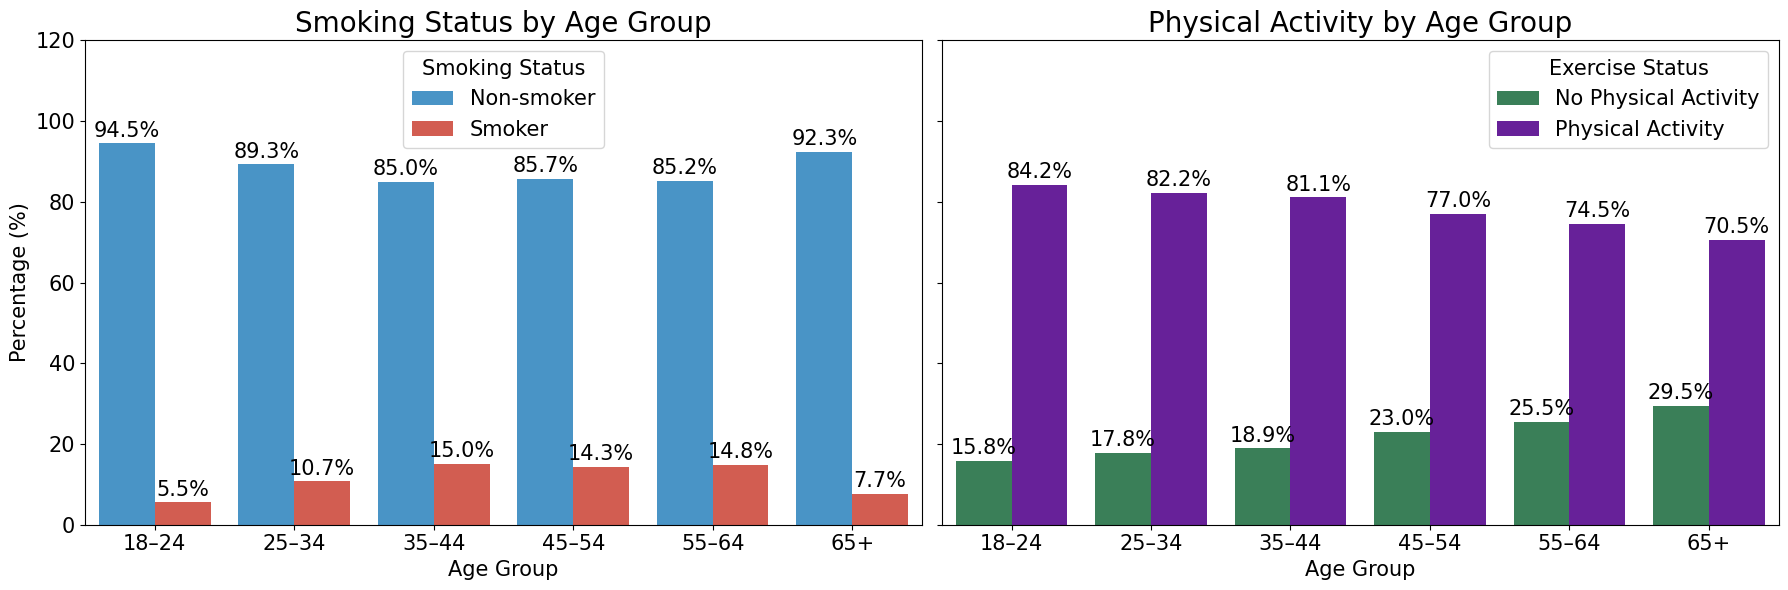

In [290]:
# Label mappings
age_labels = {
    1: '18–24',
    2: '25–34',
    3: '35–44',
    4: '45–54',
    5: '55–64',
    6: '65+'
}

smoke_labels = {
    1: 'Non-smoker',
    2: 'Smoker'
}

exercise_labels = {
    1: 'Physical Activity',
    2: 'No Physical Activity'
}

# Apply mappings
Seld['age_group'] = Seld['_AGE_G'].map(age_labels)
Seld['smoking_status'] = Seld['_RFSMOK3'].map(smoke_labels)
Seld['exercise_status'] = Seld['_TOTINDA'].map(exercise_labels)

# Drop missing
smoke_filtered = Seld.dropna(subset=['age_group', 'smoking_status'])
exercise_filtered = Seld.dropna(subset=['age_group', 'exercise_status'])

# Smoking data prep
smoke_grouped = (
    smoke_filtered.groupby(['age_group', 'smoking_status'])
    .size()
    .reset_index(name='count')
)
smoke_grouped['percentage'] = smoke_grouped.groupby('age_group')['count'].transform(lambda x: 100 * x / x.sum())
smoke_palette = {'Smoker': '#e74c3c', 'Non-smoker': '#3498db'}

# Exercise data prep
exercise_grouped = (
    exercise_filtered.groupby(['age_group', 'exercise_status'])
    .size()
    .reset_index(name='count')
)
exercise_grouped['percentage'] = exercise_grouped.groupby('age_group')['count'].transform(lambda x: 100 * x / x.sum())
exercise_palette = {'Physical Activity': '#6a0dad', 'No Physical Activity': '#2e8b57'}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Smoking plot
sb.barplot(
    data=smoke_grouped,
    x='age_group',
    y='percentage',
    hue='smoking_status',
    palette=smoke_palette,
    ax=axes[0]
)
axes[0].set_title('Smoking Status by Age Group', fontsize=20)
axes[0].set_xlabel('Age Group', fontsize=15)
axes[0].set_ylabel('Percentage (%)', fontsize=15)
axes[0].legend(title='Smoking Status', fontsize=15, title_fontsize=15)
axes[0].tick_params(axis='both', labelsize=15)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', label_type='edge', padding=2, fontsize=15)

# Exercise plot
sb.barplot(
    data=exercise_grouped,
    x='age_group',
    y='percentage',
    hue='exercise_status',
    palette=exercise_palette,
    ax=axes[1]
)
axes[1].set_title('Physical Activity by Age Group', fontsize=20)
axes[1].set_xlabel('Age Group', fontsize=15)
axes[1].set_ylabel('', fontsize=15)  # Still empty but font size is matched
axes[1].legend(title='Exercise Status', fontsize=15, title_fontsize=15)
axes[1].tick_params(axis='both', labelsize=15)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', label_type='edge', padding=2, fontsize=15)

plt.ylim(0, 120)
plt.tight_layout()
plt.show()


# New Target Variables

In [45]:
Non_diabetic = np.where(Seld['DIABETE4'].isin([3]) & Seld['PREDIAB2'].isin([3]), 1, 0)

Diabetic = np.where(Seld['DIABETE4'].isin([1]), 1, 0)

Pre_diabetic = np.where(Seld['DIABETE4'].isin([3, 4]) & Seld['PREDIAB2'].isin([1]), 1, 0)

Complication = np.where(Seld['DIABETE4'].isin([1]) & Seld['FEETSORE'].isin([1]), 1, 0)

In [122]:
pd.Series(Non_diabetic).value_counts().sum()

# Neither Diabetic or pre_diabetic

np.int64(404001)

In [202]:
pd.Series(Diabetic).value_counts().sum()

#Diabetic

np.int64(404001)

In [48]:
pd.Series(Pre_diabetic).value_counts()

#Pre_diabetic

0    382269
1     21732
Name: count, dtype: int64

In [205]:
pd.Series(Complication).value_counts().sum()
# Complications

np.int64(404001)

# Imputation

In [50]:
def sequential_hot_deck_imputer(df, group_cols, impute_cols=None):
    """
    Perform sequential hot deck imputation (forward + backward fill) on specified columns,
    grouped by the given group columns.

    Returns the DataFrame in its original order.
    """
    df_copy = df.copy()
    df_copy['_original_index'] = df_copy.index  # preserve original order

    df_sorted = df_copy.sort_values(by=group_cols)

    if impute_cols is None:
        impute_cols = df_sorted.select_dtypes(include='number').columns.difference(group_cols)

    # Forward + backward fill within each group
    df_sorted[impute_cols] = (
        df_sorted
        .groupby(group_cols)[impute_cols]
        .transform(lambda x: x.ffill().bfill())
    )

    # Restore original order
    df_restored = df_sorted.sort_values('_original_index').drop(columns=['_original_index'])
    return df_restored


   
# Example usage:
Seld_imputed = sequential_hot_deck_imputer(
    df=Seld,
    group_cols=['_SEX', '_AGE_G'],
    impute_cols=['EDUCA', 'CVDSTRK3', '_RACEPRV', 'TOLDHI3', 'CHOLMED3', 'INSULIN1', 'DIABEDU1']
)


In [51]:
Seld_drop= Seld_imputed.drop(columns=[col for col in ['FEETSORE','DIABETE4', 'PREDIAB2',
                                                      'CHOLMED3','smoking_status','age_group_label','diab_group_label','age_group','exercise_status'] if col in Seld_imputed.columns])


In [52]:
Seld_drop.isna().sum()

_SEX        0
_RFHLTH     0
_PHYS14D    0
_RFBMI5     0
_TOTINDA    0
CHOLCHK3    0
BPHIGH6     0
EDUCA       0
CVDSTRK3    0
CVDCRHD4    0
CHCSCNC1    0
_MENT14D    0
_RACEPRV    0
_RFSMOK3    0
TOLDHI3     0
_AGE_G      0
_RFBING6    0
INSULIN1    0
DIABEDU1    0
dtype: int64

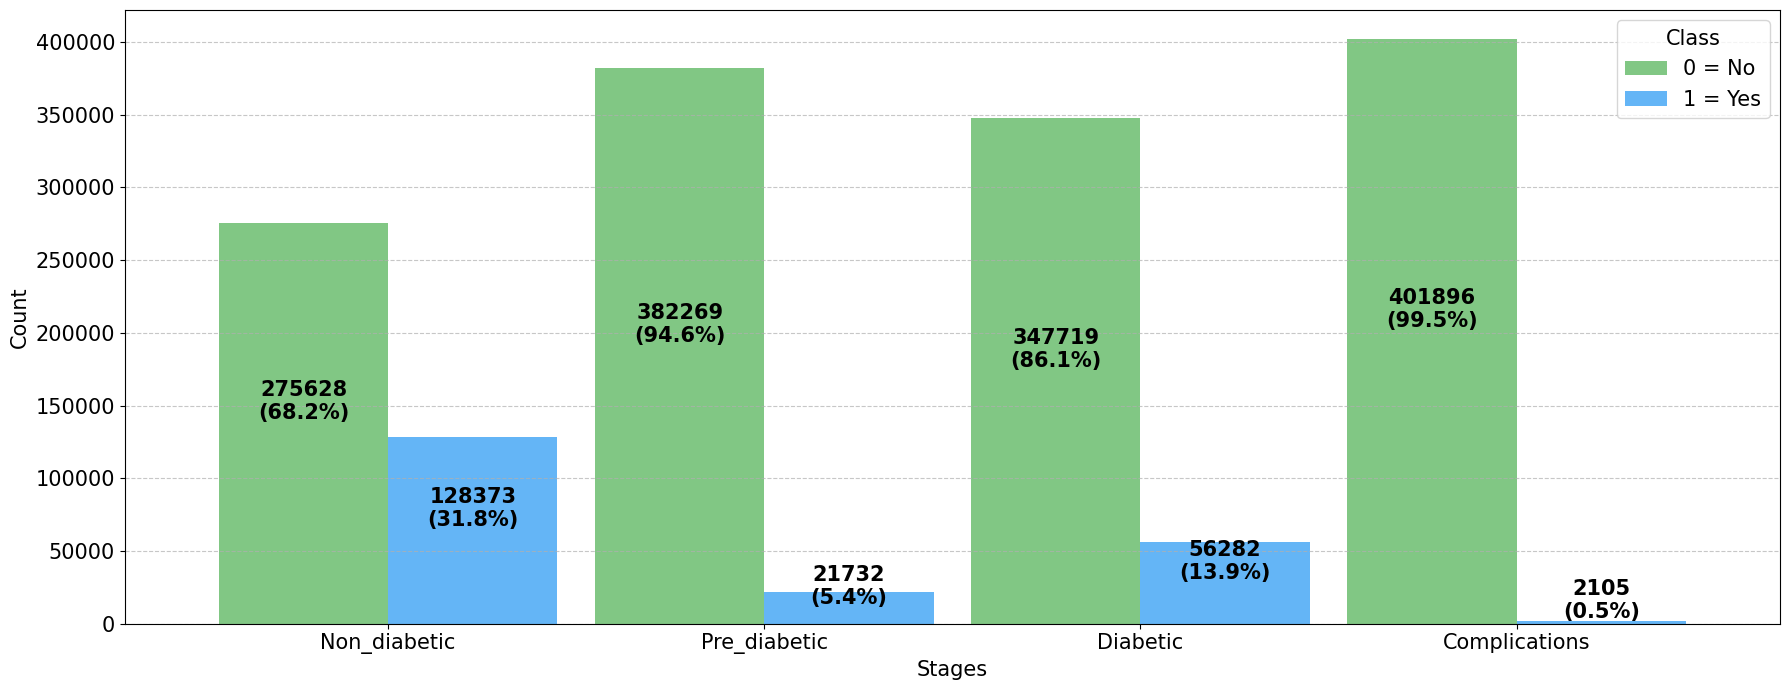

In [289]:
# Combine binary arrays into a DataFrame
df_plot = pd.DataFrame({
    'Non_diabetic': pd.Series(Non_diabetic),
    'Pre_diabetic': pd.Series(Pre_diabetic),
    'Diabetic': pd.Series(Diabetic),
    'Complications': pd.Series(Complication)
})

# Count 0s and 1s
counts_df = df_plot.apply(lambda x: x.value_counts()).T.fillna(0)

# Plot the counts
ax = counts_df.plot(kind='bar', stacked=False, color=['#81c784', '#64b5f6'], figsize=(18, 7), width=0.9)

# Axis labels
plt.xlabel('Stages', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)

# Legend with larger font
plt.legend(['0 = No', '1 = Yes'], title='Class', fontsize=15, title_fontsize=15)

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels on the bars
for i, patch in enumerate(ax.patches):
    height = patch.get_height()
    if height > 0:
        var_idx = i // 2  # two bars per variable
        var_total = counts_df.iloc[var_idx].sum()
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_y() + height / 2
        percent = height / var_total * 100
        bar_label = f'{int(height)}\n({percent:.1f}%)'
        ax.text(x, y, bar_label, ha='center', va='bottom', fontsize=15, color='black', fontweight='bold')

plt.tight_layout()
plt.show()


In [286]:
?counts_df.plot

In [180]:
import matplotlib
print(matplotlib.__version__)



3.10.1


In [54]:
Seld_drop=Seld_drop.copy()
# diabetes_map = {
#     1: 'Yes',
#     3: 'No',
#     4: 'Pre-diabetes'
# }

# Seld_drop['DIABETE4'] =Seld_drop['DIABETE4'].replace(diabetes_map)




edu_map = {
    1: 'Never attended school',
    3:'Grades 9 through 11',
    2: 'Grades 1 through 8',
    4: 'Grade 12 or GED',
    5: 'College 1 year to 3 years',
    6: 'College 4 years or more',
    7: 'Refused/D_know',
    9: 'NA'
}

Seld_drop['EDUCA'] =Seld_drop['EDUCA'].replace(edu_map)


tochl_map = {
    1: 'Yes',
    2: 'No',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['TOLDHI3'] = Seld_drop['TOLDHI3'].replace(tochl_map)

chlmed_map = {
    1: 'Yes',
    2: 'No',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['CHCSCNC1'] = Seld_drop['CHCSCNC1'].replace(chlmed_map)


CVHD_map = {
    1: 'Yes',
    2: 'No',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['CVDCRHD4'] = Seld_drop['CVDCRHD4'].replace(CVHD_map)

stroke_map = {
    1: 'Yes',
    2: 'No',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['CVDSTRK3'] = Seld_drop['CVDSTRK3'].replace(stroke_map)


bp_map = {
    1: 'Yes',
    2: 'Yes,pregnancy',
    3: 'No',
    4: 'Borderline',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['BPHIGH6'] = Seld_drop['BPHIGH6'].replace(bp_map)



# pre_diabetes_map = {
#     1: 'Yes_prediabetes',
#     3: 'No',
# }

# Selected_var_en['PREDIAB2'] = Selected_var_en['PREDIAB2'].replace(pre_diabetes_map)



sex_map = {
    1: 'Male',
    2: 'Female',
}
Seld_drop['_SEX'] = Seld_drop['_SEX'].replace(sex_map)

health_map = {
    1: 'good_hlth',
    2: 'poor_hlth',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['_RFHLTH'] =Seld_drop['_RFHLTH'].replace(health_map)

smoke_map = {
    1: 'No_smk',
    2: 'Yes_smk',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['_RFSMOK3'] = Seld_drop['_RFSMOK3'].replace(smoke_map)

drink_map = {
    1: 'No_drk',
    2: 'Yes_drk',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['_RFBING6'] = Seld_drop['_RFBING6'].replace(drink_map)


physhlth_map = {
    1: 'zero_day_of_bad_physhlth',
    2: '1-13_day_of_bad_physhlth',
    3: '14+_day_of_bad_physhlth',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['_PHYS14D'] = Seld_drop['_PHYS14D'].replace(physhlth_map)

menthlth_map = {
    1: 'zero_day_of_bad_menthlth',
    2: '1-13_day_of_bad_menthlth',
    3: '14+_day_of_bad_menthlth',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['_MENT14D'] = Seld_drop['_MENT14D'].replace(menthlth_map)




bmi_map = {
    1: 'No',
    2: 'Yes',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['_RFBMI5'] = Seld_drop['_RFBMI5'].replace(bmi_map)



exer_map = {
    1: 'Had physical activity',
    2: 'No physical activity',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['_TOTINDA'] = Seld_drop['_TOTINDA'].replace(exer_map)



race_map = {
    1: 'White only',
    2: 'Black only',
    3: 'American Indian',
    4:'Asian only',
    5:'Native Hawaiian',
    6:'Other race only',
    7:'Multiracial',
    8:'Hispanic'
    
}
Seld_drop['_RACEPRV'] = Seld_drop['_RACEPRV'].replace(race_map)

# blood_sugar_map = {
#     1: 'Within the past year',
#     2: 'Within the past 2 years',
#     3: 'Within the past 3 years ',
#     4:'Within the past 5 years',
#     5:'Within the past 10 years',
#     6:'10 or more years ago'
# }
# Selected_var_en['PDIABTS1'] = Selected_var_en['PDIABTS1'].replace(blood_sugar_map)

agerange_map = {
    1: 'Age 18 to 24',
    2: 'Age 25 to 34',
    3: 'Age 35 to 44',
    4:'Age 45 to 54',
    5:'Age 55 to 64',
    6:'Age 65 or older'
}
Seld_drop['_AGE_G'] = Seld_drop['_AGE_G'].replace(agerange_map)


# eyephoto_map = {
#     1: 'Within the past month',
#     2: 'Within the past year',
#     3: 'Within the past 2 years',
#     4: '2 or more years ago',
#     8: 'Never'
# }
# Selected_var_en['DIABEYE1'] = Selected_var_en['DIABEYE1'].replace(eyephoto_map)


# eyexam_map = {
#     1: 'Within the past month',
#     2: 'Within the past year',
#     3: 'Within the past 2 years',
#     4: '2 or more years ago',
#     8: 'Never'
# }
# Selected_var_en['EYEEXAM1'] = Selected_var_en['EYEEXAM1'].replace(eyexam_map)

diabedu_map = {
    1: 'Within the past year',
    2: 'Within the past 2 years',
    3: 'Within the past 3 years ',
    4:'Within the past 5 years',
    5:'Within the past 10 years',
    6:'10 or more years ago',
    8: 'Never',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['DIABEDU1'] = Seld_drop['DIABEDU1'].replace(diabedu_map)








cholck_map = {
    2: 'Within the past year',
    3: 'Within the past 2 years',
    4: 'Within the past 3 years ',
    5:'Within the past 4 years',
    6:'Within the past 5 years',
    8: '5 or more years ago',
    1: 'Never',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['CHOLCHK3'] = Seld_drop['CHOLCHK3'].replace(cholck_map)


insul_map = {
    1: 'Yes',
    2: 'No',
    7: 'Refused/D_know',
    9: 'NA'
}
Seld_drop['INSULIN1'] = Seld_drop['INSULIN1'].replace(insul_map)



# food_map = {
#     1: 'Yes',
#     2: 'No',
# }
# Selected_var_en['FOODSTMP'] = Selected_var_en['FOODSTMP'].replace(food_map)


# feetsore_map = {
#     1: 'Yes',
#     2: 'No',
# }
# Selected_var_en['FEETSORE'] = Selected_var_en['FEETSORE'].replace(feetsore_map)


Seld_drop.head()

,_SEX,_RFHLTH,_PHYS14D,_RFBMI5,_TOTINDA,CHOLCHK3,BPHIGH6,EDUCA,CVDSTRK3,CVDCRHD4,CHCSCNC1,_MENT14D,_RACEPRV,_RFSMOK3,TOLDHI3,_AGE_G,_RFBING6,INSULIN1,DIABEDU1
0,Female,good_hlth,zero_day_of_bad_physhlth,Yes,No physical activity,Within the past 2 years,Yes,College 1 year to 3 years,No,No,No,zero_day_of_bad_menthlth,White only,No_smk,No,Age 65 or older,No_drk,NA,NA
1,Female,good_hlth,zero_day_of_bad_physhlth,Yes,Had physical activity,Within the past year,Yes,College 1 year to 3 years,No,No,No,zero_day_of_bad_menthlth,White only,No_smk,Yes,Age 65 or older,No_drk,NA,NA
2,Female,poor_hlth,1-13_day_of_bad_physhlth,No,Had physical activity,Within the past year,Yes,Grade 12 or GED,No,No,No,1-13_day_of_bad_menthlth,Black only,No_smk,Yes,Age 65 or older,No_drk,NA,NA
3,Female,good_hlth,1-13_day_of_bad_physhlth,Yes,Had physical activity,Within the past 2 years,No,College 1 year to 3 years,No,No,Yes,zero_day_of_bad_menthlth,White only,No_smk,No,Age 65 or older,No_drk,NA,NA
4,Female,poor_hlth,zero_day_of_bad_physhlth,Yes,Had physical activity,Within the past year,Yes,College 1 year to 3 years,No,No,No,zero_day_of_bad_menthlth,White only,No_smk,No,Age 65 or older,No_drk,NA,NA


# Non- diabetic 

In [198]:
X = Seld_drop
y0 = Non_diabetic
y1 = Diabetic
y2 =Pre_diabetic
y3 =Complication

Y=np.column_stack((y0,y1,y2,y3))

y= pd.DataFrame(Y, columns=['non_diabetic', 'Diabetic', 
                                'prediabetic', 'Complications'])


# One-hot encode (all categories retained)
X_encoded = pd.get_dummies(X, drop_first=False)

# # Convert boolean columns to int for SMOTE compatibility
X_encoded = X_encoded.astype({col: 'int' for col in X_encoded.select_dtypes(include='bool').columns})

X_encoded.shape

(404001, 90)

# Splitting

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)


def joint_oversample(X, Y, random_state=42):
   
    y_joint = Y.astype(str).agg('_'.join, axis=1) # Combine multi-label outputs into a single string label per row

    ros = RandomOverSampler(random_state=random_state)
    X_res, y_joint_res = ros.fit_resample(X, y_joint)

    
    y_res = y_joint_res.str.split('_', expand=True).astype(int)# Split the joint labels back to original columns
    y_res.columns = Y.columns

    return X_res.reset_index(drop=True), y_res.reset_index(drop=True)

X_balanced, y_balanced = joint_oversample(X_train, y_train)




def joint_undersample(X, Y, random_state=42):
    
    y_joint = Y.astype(str).agg('_'.join, axis=1)# Combine multi-label outputs into a single string label per row

    rus = RandomUnderSampler(random_state=random_state)
    X_res, y_joint_res = rus.fit_resample(X, y_joint)

    
    y_res = y_joint_res.str.split('_', expand=True).astype(int)# Split the joint labels back to original columns
    y_res.columns = Y.columns

    return X_res.reset_index(drop=True), y_res.reset_index(drop=True)

X_Ubalanced,y_Ubalanced = joint_undersample(X_train, y_train)

In [57]:
y_Ubalanced['Complications'].value_counts()

Complications
0    6736
1    1684
Name: count, dtype: int64

In [115]:
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import ADASYN
# from imblearn.under_sampling import RandomUnderSampler

# # Use stratified train-test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_encoded, y, test_size=0.2, random_state=42, stratify=y
# )

# # SMOTE-based oversampling for joint multilabels
# def joint_oversample_smote(X, Y, random_state=42):
#     y_joint = Y.astype(str).agg('_'.join, axis=1)  # Combine multi-label outputs into a single string label per row

#     smote = SMOTE(random_state=random_state)
#     X_res, y_joint_res = smote.fit_resample(X, y_joint)

#     y_res = y_joint_res.str.split('_', expand=True).astype(int)  # Split joint labels back into original columns
#     y_res.columns = Y.columns

#     return X_res.reset_index(drop=True), y_res.reset_index(drop=True)


# def joint_oversample_adasyn(X, Y, random_state=42):
#     # Combine multilabels into one string per row (e.g., "1_0_1")
#     y_joint = Y.astype(str).agg('_'.join, axis=1)

#     adasyn = ADASYN(random_state=random_state)
#     X_res, y_joint_res = adasyn.fit_resample(X, y_joint)

#     # Split the combined label back into original columns
#     y_res = y_joint_res.str.split('_', expand=True).astype(int)
#     y_res.columns = Y.columns

#     return X_res.reset_index(drop=True), y_res.reset_index(drop=True)
# # Apply them
# X_balanced1, y_balanced1 = joint_oversample_smote(X_train, y_train)
# X_Ubalanced1, y_Ubalanced1 = joint_oversample_adasyn(X_train, y_train)


In [116]:
y_balanced['Complications'].value_counts()

Complications
0    632364
1    158091
Name: count, dtype: int64

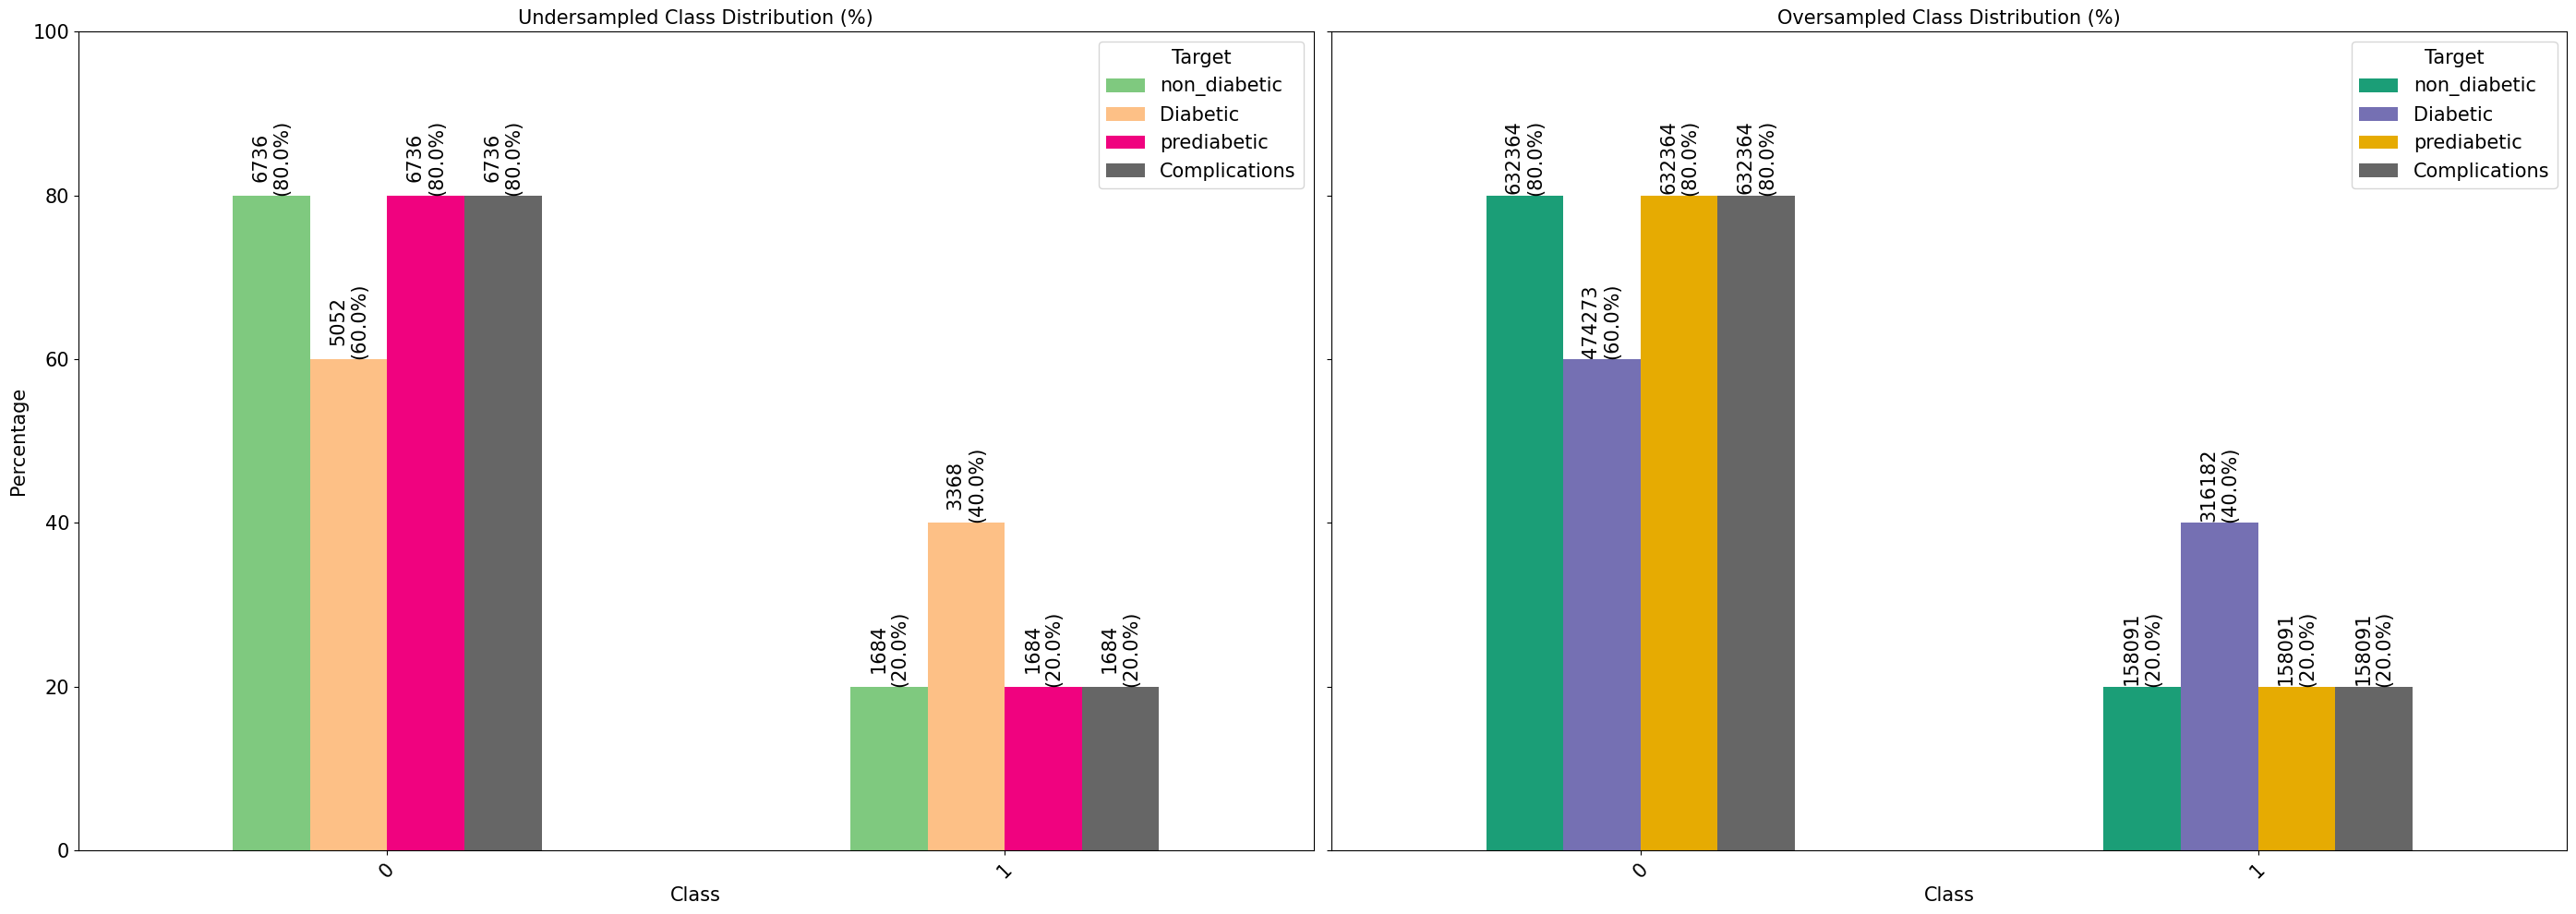

In [163]:
# ----- Calculate raw counts and percentages -----
count_ub = {col: y_Ubalanced[col].value_counts() for col in y_Ubalanced.columns}
percent_ub = {col: y_Ubalanced[col].value_counts(normalize=True) * 100 for col in y_Ubalanced.columns}

count_b = {col: y_balanced[col].value_counts() for col in y_balanced.columns}
percent_b = {col: y_balanced[col].value_counts(normalize=True) * 100 for col in y_balanced.columns}

# Convert to DataFrames and fill missing values
count_df_ub = pd.DataFrame(count_ub).fillna(0).astype(int)
percent_df_ub = pd.DataFrame(percent_ub).fillna(0)

count_df_b = pd.DataFrame(count_b).fillna(0).astype(int)
percent_df_b = pd.DataFrame(percent_b).fillna(0)

# ----- Create side-by-side subplots -----
fig, axes = plt.subplots(1, 2, figsize=(28, 10), sharey=True)

# --- Plot Unbalanced ---
ax1 = percent_df_ub.plot(kind='bar', ax=axes[0], rot=45, colormap='Accent', legend=True)
ax1.set_title('Undersampled Class Distribution (%)', fontsize=15)
ax1.set_ylim(0, 100)
ax1.set_xlabel('Class', fontsize=15)
ax1.set_ylabel('Percentage', fontsize=15)
ax1.tick_params(axis='both', labelsize=15)
ax1.legend(fontsize=15, title='Target', title_fontsize=15)

# Annotate bars (Unbalanced)
for idx, p in enumerate(ax1.patches):
    height = p.get_height()
    if height > 0:
        col = percent_df_ub.columns[idx // len(percent_df_ub)]
        row = percent_df_ub.index[idx % len(percent_df_ub)]
        count = count_df_ub.loc[row, col]
        ax1.annotate(f'{count}\n({height:.1f}%)',
                     (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom', rotation=90, fontsize=15)

# --- Plot Balanced ---
ax2 = percent_df_b.plot(kind='bar', ax=axes[1], rot=45, colormap='Dark2', legend=True)
ax2.set_title('Oversampled Class Distribution (%)', fontsize=15)
ax2.set_ylim(0, 100)
ax2.set_xlabel('Class', fontsize=15)
ax2.set_ylabel('', fontsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax2.legend(fontsize=15, title='Target', title_fontsize=15)

# Annotate bars (Balanced)
for idx, p in enumerate(ax2.patches):
    height = p.get_height()
    if height > 0:
        col = percent_df_b.columns[idx // len(percent_df_b)]
        row = percent_df_b.index[idx % len(percent_df_b)]
        count = count_df_b.loc[row, col]
        ax2.annotate(f'{count}\n({height:.1f}%)',
                     (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom', rotation=90, fontsize=15)

# Final layout
plt.tight_layout()
plt.show()


# Random Forest

# Oversampling


In [128]:
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
multi_rf = MultiOutputClassifier(base_rf)

# Step 2: Set hyperparameter grid
param_grid = {
    'estimator__n_estimators': [300, 100, 200],
    'estimator__max_depth': [5, None, 10, 20],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
}

# Step 3: Apply Grid Search
random_search = RandomizedSearchCV(
    estimator=multi_rf,
    param_distributions=param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_balanced, y_balanced)

# Step 4: Best estimator
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=300; total time=36.5min
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=13.2min
[CV] END estimator__max_depth=20, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time=19.6min
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=300; total time=62.5min


/home/students150/myenv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=300; total time=35.6min
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=300; total time=35.6min
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=300; total time=64.2min
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=200; total time=140.6min
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=300; total time=36.0min
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=300; total time=36.4min
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=30

Accuracy (subset): 0.33495872575834457
Micro F1 Score: 0.4305369017590985
Macro F1 Score: 0.324573818040156
Micro Precision: 0.32690370480916314
Micro Recall: 0.6303748291325931

Classification Report:

              precision    recall  f1-score   support

           0       0.38      0.73      0.50     25675
           1       0.65      0.53      0.58     11257
           2       0.08      0.37      0.13      4346
           3       0.13      0.07      0.09       421

   micro avg       0.33      0.63      0.43     41699
   macro avg       0.31      0.43      0.32     41699
weighted avg       0.42      0.63      0.48     41699
 samples avg       0.29      0.32      0.30     41699


ROC AUC (macro): 0.7760
ROC AUC (micro): 0.8326


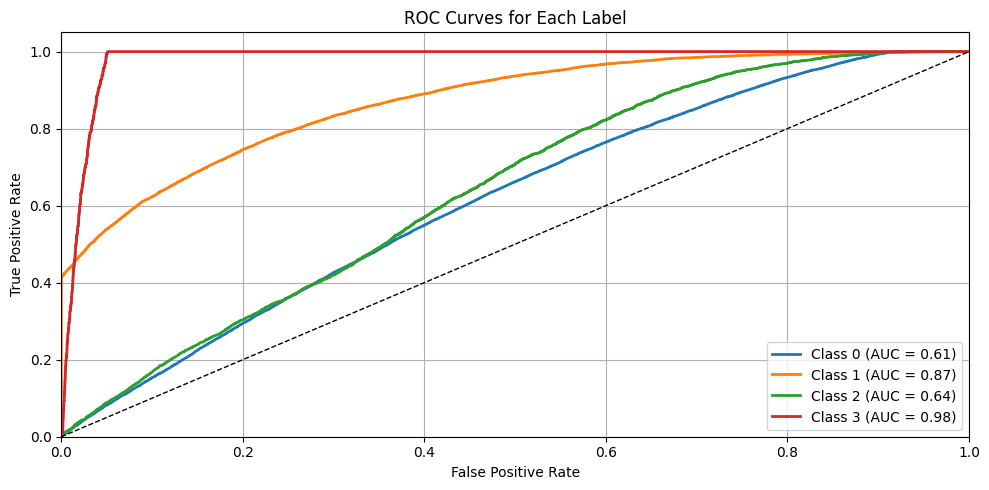

In [167]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities
y_proba = best_model.predict_proba(X_test)

# Convert list of arrays (per label) to a 2D array of shape (n_samples, n_labels)
# Each column is probability of the positive class for that label
y_proba_matrix = np.column_stack([proba[:, 1] for proba in y_proba])

# Predict class labels using default threshold = 0.5
y_pred = (y_proba_matrix >= 0.5).astype(int)

# === Classification Metrics ===
print("Accuracy (subset):", accuracy_score(y_test, y_pred))
print("Micro F1 Score:", f1_score(y_test, y_pred, average='micro'))
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Micro Precision:", precision_score(y_test, y_pred, average='micro'))
print("Micro Recall:", recall_score(y_test, y_pred, average='micro'))

# Optional: Detailed per-label report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# === ROC AUC Scores ===
roc_auc_macro = roc_auc_score(y_test, y_proba_matrix, average='macro')
roc_auc_micro = roc_auc_score(y_test, y_proba_matrix, average='micro')
print(f"\nROC AUC (macro): {roc_auc_macro:.4f}")
print(f"ROC AUC (micro): {roc_auc_micro:.4f}")

# === ROC Curves ===
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Create ROC curve for each label
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_proba_matrix[:, i])
    roc_auc[i] = roc_auc_score(y_test.iloc[:, i], y_proba_matrix[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Label')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


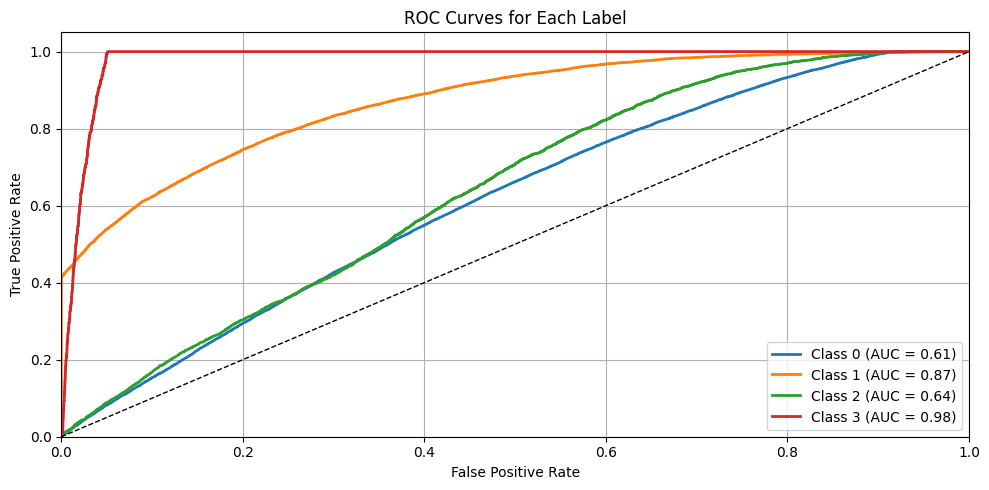

In [168]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# === ROC Curves ===
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Create ROC curve for each label
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_proba_matrix[:, i])
    roc_auc[i] = roc_auc_score(y_test.iloc[:, i], y_proba_matrix[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Label')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [131]:
# Step 5: Evaluate on test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))



predictions =best_model.predict(X_test)

label_names = ['non_diabetic', 'Diabetic', 'prediabetic', 'Complications']

for i, label in enumerate(label_names):
    print(f"\n=== Classification Report for '{label}' ===")
    print(classification_report(y_test[label], predictions[:, i], zero_division=0))


              precision    recall  f1-score   support

           0       0.38      0.73      0.50     25675
           1       0.65      0.53      0.58     11257
           2       0.08      0.37      0.13      4346
           3       0.13      0.07      0.09       421

   micro avg       0.33      0.63      0.43     41699
   macro avg       0.31      0.43      0.32     41699
weighted avg       0.42      0.63      0.48     41699
 samples avg       0.29      0.32      0.30     41699


=== Classification Report for 'non_diabetic' ===
              precision    recall  f1-score   support

           0       0.78      0.44      0.56     55126
           1       0.38      0.73      0.50     25675

    accuracy                           0.53     80801
   macro avg       0.58      0.58      0.53     80801
weighted avg       0.65      0.53      0.54     80801


=== Classification Report for 'Diabetic' ===
              precision    recall  f1-score   support

           0       0.93      0.95

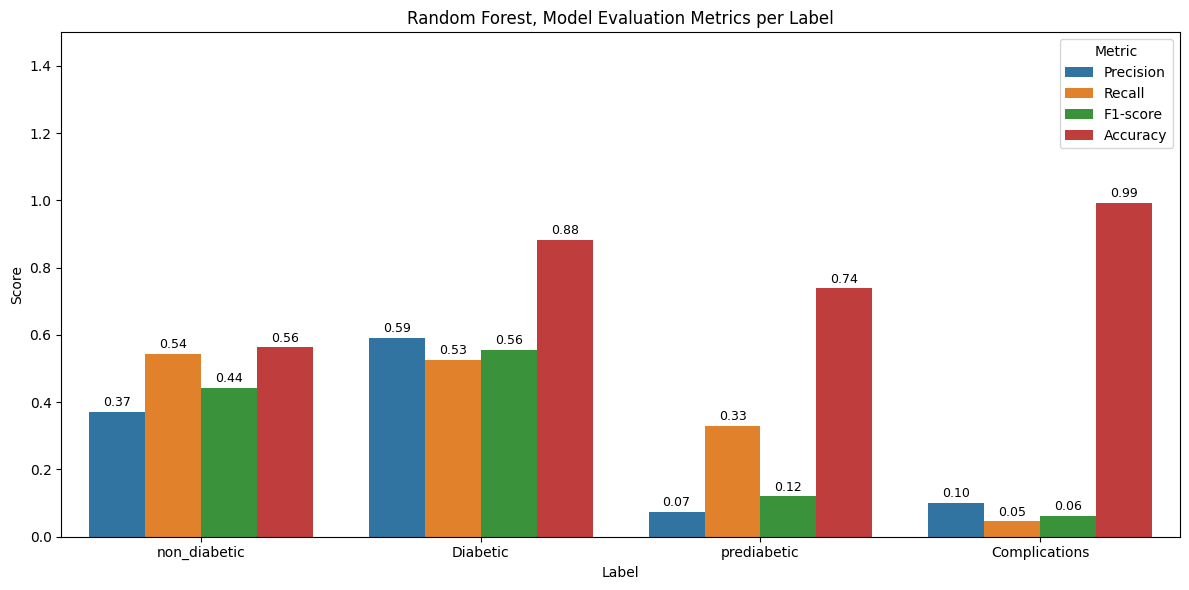

In [109]:
metrics = {'Label': [], 'Metric': [], 'Score': []}

for i, label in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], predictions[:, i], average='binary', zero_division=0
    )
    acc = accuracy_score(y_test[label], predictions[:, i])

    metrics['Label'].extend([label] * 4)
    metrics['Metric'].extend(['Precision', 'Recall', 'F1-score', 'Accuracy'])
    metrics['Score'].extend([precision, recall, f1, acc])

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Plot
plt.figure(figsize=(12, 6))
ax = sb.barplot(x='Label', y='Score', hue='Metric', data=df_metrics)
plt.title('Random Forest, Model Evaluation Metrics per Label')
plt.ylim(0, 1.5)
plt.ylabel('Score')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=2)

plt.tight_layout()
plt.show()


# undersample

In [66]:
# rf1 = MultiOutputClassifier(RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1))
# rf1.fit(X_Ubalanced, y_Ubalanced)


In [67]:
base_rf1 = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
multi_rf1 = MultiOutputClassifier(base_rf)

# Step 2: Set hyperparameter grid
param_grid = {
    'estimator__n_estimators': [ 300, 100, 200],
    'estimator__max_depth': [ None, 10],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2]
}

# Step 3: Apply Grid Search
random_search = RandomizedSearchCV(
    estimator=multi_rf1,
     param_distributions=param_grid,
    cv=5,
    verbose=2,
    n_jobs=2
)

random_search.fit(X_Ubalanced, y_Ubalanced)

# Step 4: Best estimator
best_model_1 = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)



[CV] END estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=23.4min
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=200; total time=19.8min
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=300; total time=57.8min
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=10.7min
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time=12.1min
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time= 7.7min
[CV] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=200; t

In [68]:
predictions1 =best_model_1.predict(X_test)

label_names = ['non_diabetic', 'Diabetic', 'prediabetic', 'Complications']

for i, label in enumerate(label_names):
    print(f"\n=== Classification Report for '{label}' ===")
    print(classification_report(y_test[label], predictions1[:, i], zero_division=0))



=== Classification Report for 'non_diabetic' ===
              precision    recall  f1-score   support

           0       0.70      0.82      0.76     55126
           1       0.38      0.24      0.29     25675

    accuracy                           0.64     80801
   macro avg       0.54      0.53      0.52     80801
weighted avg       0.60      0.64      0.61     80801


=== Classification Report for 'Diabetic' ===
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     69544
           1       0.65      0.50      0.57     11257

    accuracy                           0.89     80801
   macro avg       0.78      0.73      0.75     80801
weighted avg       0.88      0.89      0.89     80801


=== Classification Report for 'prediabetic' ===
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     76455
           1       0.08      0.23      0.12      4346

    accuracy                         

In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

summary = {
    'Label': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for i, label in enumerate(label_names):
    y_true = y_test.iloc[:, i]
    y_pred = predictions1[:, i]
    
    summary['Label'].append(label)
    summary['Precision'].append(precision_score(y_true, y_pred, zero_division=0))
    summary['Recall'].append(recall_score(y_true, y_pred, zero_division=0))
    summary['F1 Score'].append(f1_score(y_true, y_pred, zero_division=0))

summary_df = pd.DataFrame(summary)
print("\n=== Per Label Evaluation Summary ===")
print(summary_df.round(3))



=== Per Label Evaluation Summary ===
           Label  Precision  Recall  F1 Score
0   non_diabetic      0.384   0.237     0.293
1       Diabetic      0.648   0.502     0.566
2    prediabetic      0.082   0.232     0.121
3  Complications      0.106   0.888     0.189


In [70]:
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# import matplotlib.pyplot as plt

# for i, label in enumerate(label_names):
#     cm = confusion_matrix(y_test.iloc[:, i], predictions1[:, i])
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
#     disp.plot(cmap='Blues')
#     plt.title(f"Confusion Matrix - {label}")
#     plt.grid(False)
#     plt.show()


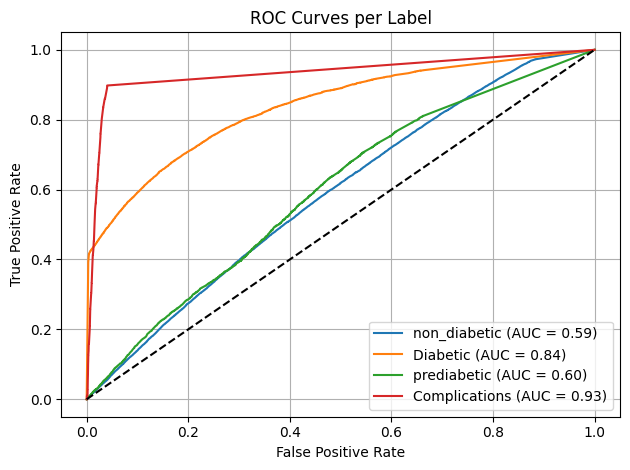

In [71]:
# from sklearn.metrics import roc_curve, roc_auc_score

# # Convert list of proba arrays to 2D matrix
# y_proba_matrix = np.column_stack([p[:, 1] for p in y_proba])

# for i, label in enumerate(label_names):
#     y_true = y_test.iloc[:, i]
#     y_score = y_proba_matrix[:, i]

#     fpr, tpr, _ = roc_curve(y_true, y_score)
#     auc = roc_auc_score(y_true, y_score)

#     plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves per Label")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [72]:
precision = precision_score(y_test, predictions1, average='macro')
print(precision)

0.30478030894853425


In [73]:
# rf_best = RandomForestClassifier(
#     n_estimators=2000,          
#     max_depth=None,             
#     min_samples_split=3,        
#     min_samples_leaf=3,        
#     random_state=42,
#     n_jobs=-1
# )

# # Wrap in MultiOutputClassifier
# rf1 = MultiOutputClassifier(rf_best)

# # Fit on undersampled (balanced) data
# rf1.fit(X_Ubalanced, y_Ubalanced)

In [74]:
predictions1 =best_model_1.predict(X_test)

label_names = ['non_diabetic', 'Diabetic', 'prediabetic', 'Complications']

for i, label in enumerate(label_names):
    print(f"\n=== Classification Report for '{label}' ===")
    print(classification_report(y_test[label], predictions1[:, i], zero_division=0))



=== Classification Report for 'non_diabetic' ===
              precision    recall  f1-score   support

           0       0.70      0.82      0.76     55126
           1       0.38      0.24      0.29     25675

    accuracy                           0.64     80801
   macro avg       0.54      0.53      0.52     80801
weighted avg       0.60      0.64      0.61     80801


=== Classification Report for 'Diabetic' ===
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     69544
           1       0.65      0.50      0.57     11257

    accuracy                           0.89     80801
   macro avg       0.78      0.73      0.75     80801
weighted avg       0.88      0.89      0.89     80801


=== Classification Report for 'prediabetic' ===
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     76455
           1       0.08      0.23      0.12      4346

    accuracy                         

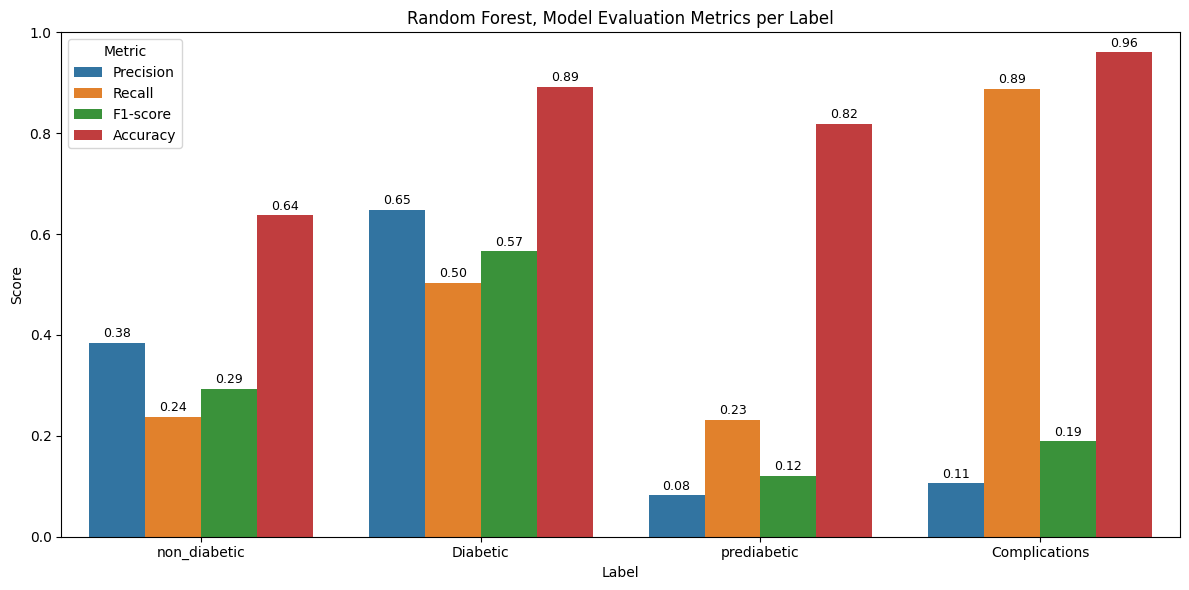

In [75]:
metrics = {'Label': [], 'Metric': [], 'Score': []}

for i, label in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], predictions1[:, i], average='binary', zero_division=0
    )
    acc = accuracy_score(y_test[label], predictions1[:, i])

    metrics['Label'].extend([label] * 4)
    metrics['Metric'].extend(['Precision', 'Recall', 'F1-score', 'Accuracy'])
    metrics['Score'].extend([precision, recall, f1, acc])

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Plot
plt.figure(figsize=(12, 6))
ax = sb.barplot(x='Label', y='Score', hue='Metric', data=df_metrics)
plt.title('Random Forest, Model Evaluation Metrics per Label')
plt.ylim(0, 1)
plt.ylabel('Score')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=2)

plt.tight_layout()
plt.show()


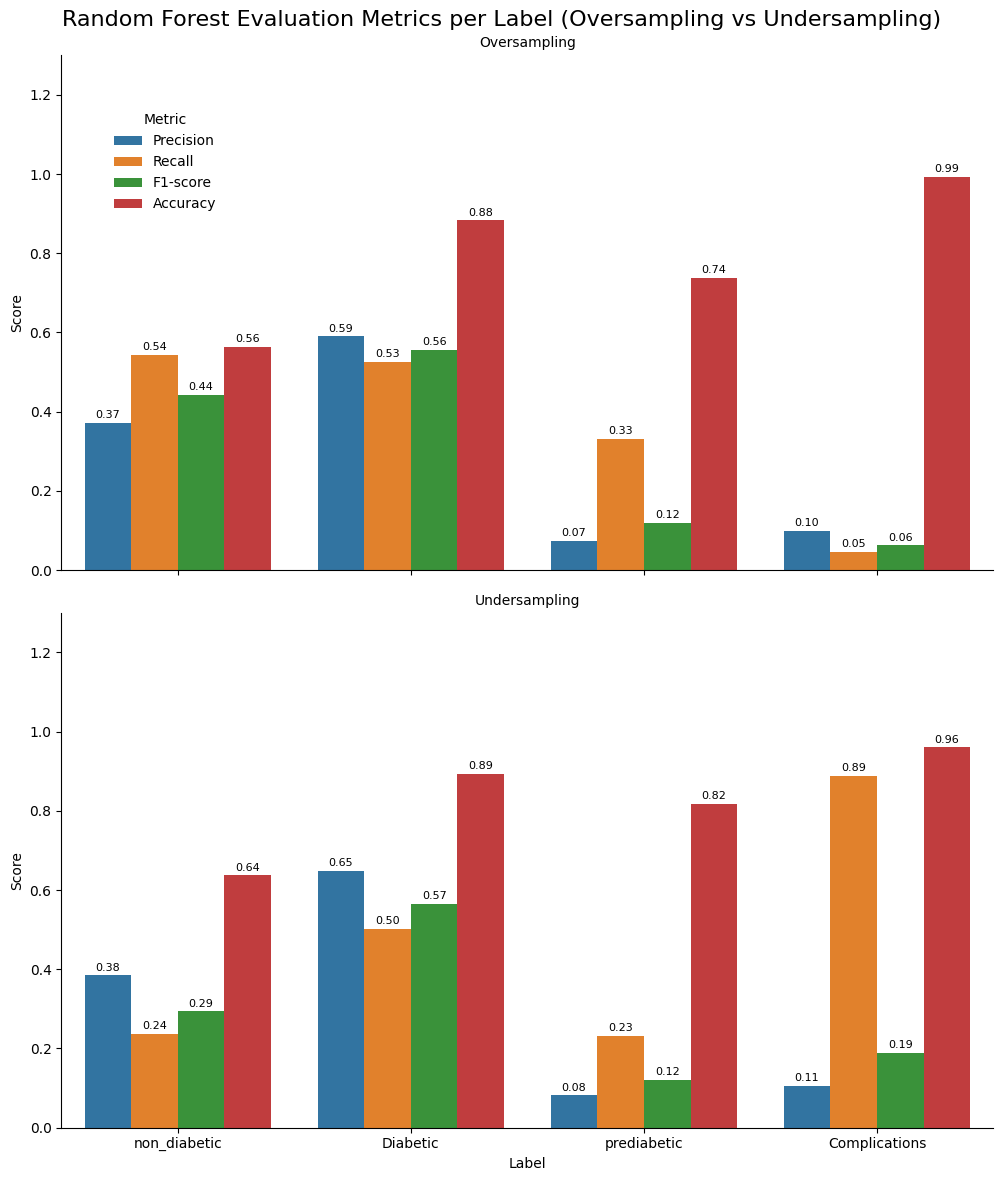

In [110]:
# --- Plot vertically and adjust legend ---
g = sb.catplot(
    data=df_combined,
    x='Label', y='Score', hue='Metric',
    row='Sampling', kind='bar',  # <-- use row instead of col
    height=6, aspect=1.5
)

g.set_titles("{row_name}")
g.set_axis_labels("Label", "Score")
g.set(ylim=(0, 1.3))
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Random Forest Evaluation Metrics per Label (Oversampling vs Undersampling)", fontsize=16)

# Shift legend to upper left
g._legend.set_bbox_to_anchor((0.10, 0.90))
g._legend.set_loc('upper left')

# Add value labels to bars
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8, padding=2)

plt.tight_layout()
plt.show()


# MLP Classifier

In [77]:
# mlp = MLPClassifier(
#     hidden_layer_sizes=(100,),  # You can adjust this
#     activation='relu',
#     solver='adam',
#     max_iter=300,
#     random_state=42
# )

# # Wrap with MultiOutputClassifier for multi-label targets
# model = MultiOutputClassifier(mlp)

# # Fit the model
# model.fit(X_balanced, y_balanced)

In [78]:
# Base model
mlp = MLPClassifier(random_state=42, max_iter=500)

# Multi-output wrapper
multi_mlp = MultiOutputClassifier(mlp)

# Define parameter grid
param_grid = {
    'estimator__hidden_layer_sizes': [(50,)],
    'estimator__activation': ['relu'],
    'estimator__solver': ['adam'],
    'estimator__learning_rate': ['constant'],
    'estimator__alpha': [0.01],
}

# Grid Search
random_search =RandomizedSearchCV(
    multi_mlp,
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
random_search.fit(X_balanced, y_balanced)

# Best model
best_model1 = random_search.best_estimator_

# Best parameters
print("Best Parameters:\n", random_search.best_params_)


[CV] END estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   1.4s
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   1.1s
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=200; total time=   2.4s
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=200; total time=   2.5s
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=200; total time=   2.4s
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=300; total time=   3.1s
[CV] END estimator__max_depth=10, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=300

/home/students150/myenv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END estimator__activation=relu, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50,), estimator__learning_rate=constant, estimator__solver=adam; total time=27.8min
[CV] END estimator__activation=relu, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50,), estimator__learning_rate=constant, estimator__solver=adam; total time=28.6min
[CV] END estimator__activation=relu, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50,), estimator__learning_rate=constant, estimator__solver=adam; total time=28.8min
[CV] END estimator__activation=relu, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50,), estimator__learning_rate=constant, estimator__solver=adam; total time=29.4min
[CV] END estimator__activation=relu, estimator__alpha=0.01, estimator__hidden_layer_sizes=(50,), estimator__learning_rate=constant, estimator__solver=adam; total time=30.0min
Best Parameters:
 {'estimator__solver': 'adam', 'estimator__learning_rate': 'constant', 'estimator__hidden_layer_sizes': (50,

In [79]:
predictions2 =best_model1.predict(X_test)

label_names = ['non_diabetic', 'Diabetic', 'prediabetic', 'Complications']

for i, label in enumerate(label_names):
    print(f"\n=== Classification Report for '{label}' ===")
    print(classification_report(y_test[label], predictions2[:, i], zero_division=0))



=== Classification Report for 'non_diabetic' ===
              precision    recall  f1-score   support

           0       0.69      0.93      0.79     55126
           1       0.44      0.12      0.19     25675

    accuracy                           0.67     80801
   macro avg       0.57      0.52      0.49     80801
weighted avg       0.61      0.67      0.60     80801


=== Classification Report for 'Diabetic' ===
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     69544
           1       0.90      0.45      0.60     11257

    accuracy                           0.92     80801
   macro avg       0.91      0.72      0.78     80801
weighted avg       0.91      0.92      0.90     80801


=== Classification Report for 'prediabetic' ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     76455
           1       0.14      0.03      0.05      4346

    accuracy                         

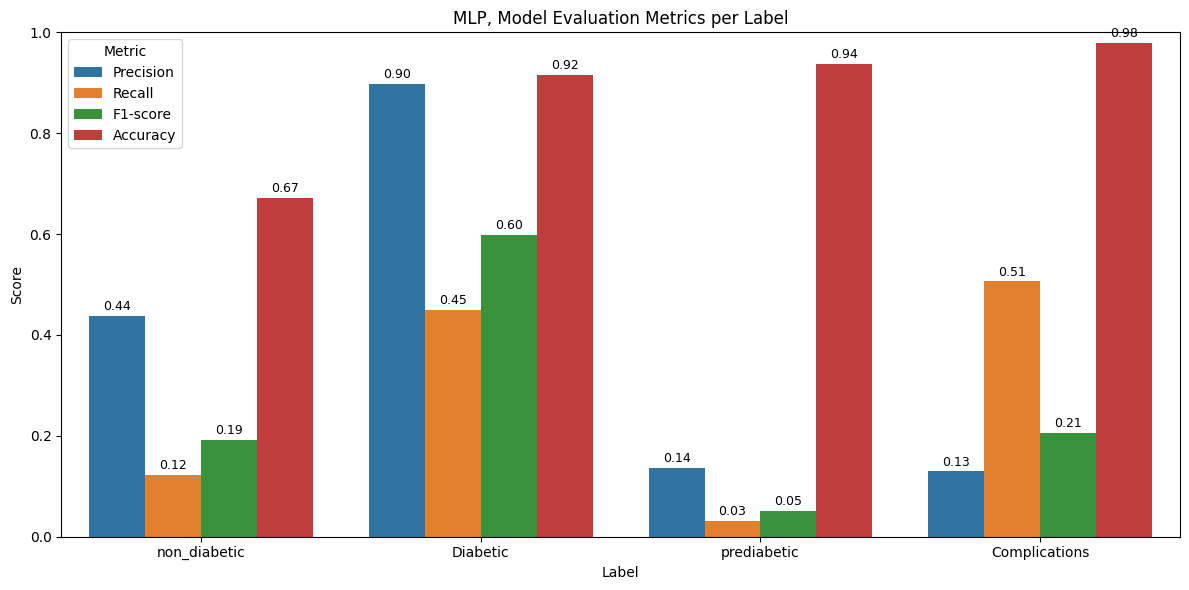

In [114]:
metrics = {'Label': [], 'Metric': [], 'Score': []}

for i, label in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], predictions2[:, i], average='binary', zero_division=0
    )
    acc = accuracy_score(y_test[label], predictions2[:, i])

    metrics['Label'].extend([label] * 4)
    metrics['Metric'].extend(['Precision', 'Recall', 'F1-score', 'Accuracy'])
    metrics['Score'].extend([precision, recall, f1, acc])

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Plot
plt.figure(figsize=(12, 6))
ax = sb.barplot(x='Label', y='Score', hue='Metric', data=df_metrics)
plt.title('MLP, Model Evaluation Metrics per Label')
plt.ylim(0, 1)
plt.ylabel('Score')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=2)

plt.tight_layout()
plt.show()


In [81]:
# Get predicted probabilities
y_proba = best_model1.predict_proba(X_test)
y_proba_matrix = np.column_stack([proba[:, 1] for proba in y_proba])

print("\n=== ROC-AUC Scores ===")
for i, label in enumerate(label_names):
    auc = roc_auc_score(y_test[label], y_proba_matrix[:, i])
    print(f"{label}: AUC = {auc:.4f}")



=== ROC-AUC Scores ===
non_diabetic: AUC = 0.6281
Diabetic: AUC = 0.8863
prediabetic: AUC = 0.6861
Complications: AUC = 0.9792


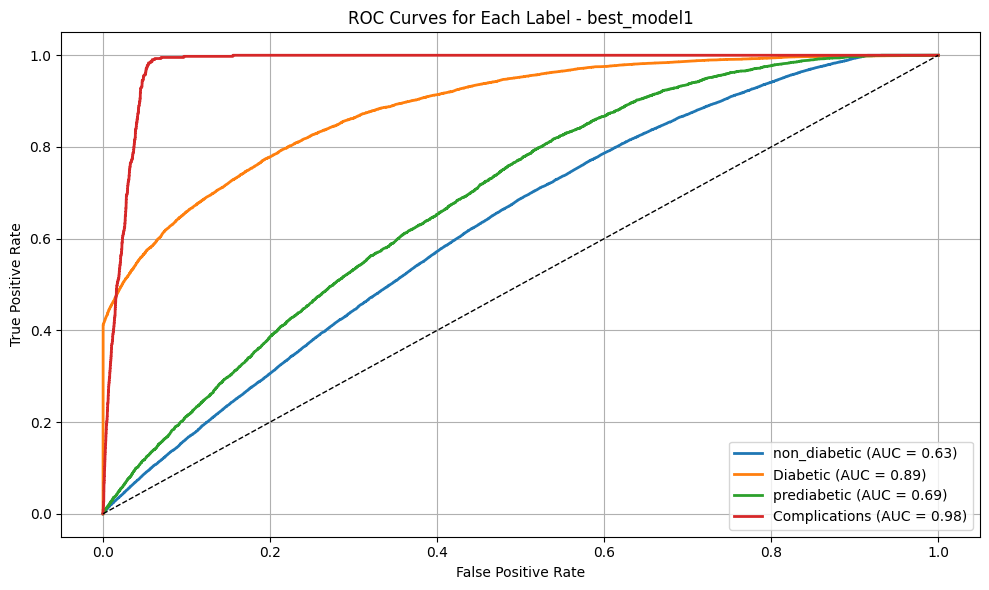

In [82]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, label in enumerate(label_names):
    fpr, tpr, _ = roc_curve(y_test[label], y_proba_matrix[:, i])
    auc = roc_auc_score(y_test[label], y_proba_matrix[:, i])
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Label - best_model1")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# undersample

In [84]:
# Base model
mlp = MLPClassifier(random_state=42, max_iter=10000)

# Multi-output wrapper
multi_mlp = MultiOutputClassifier(mlp)

# Define parameter grid
param_grid = {
    'estimator__hidden_layer_sizes': [(100,)],
    'estimator__activation': [ 'relu'],
    'estimator__solver': ['adam'],
    'estimator__learning_rate': ['constant'],
    'estimator__alpha': [ 0.001],
}

# Grid Search
random_search = RandomizedSearchCV(
    multi_mlp,
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
random_search.fit(X_Ubalanced, y_Ubalanced)

# Best model
best_model2 = random_search.best_estimator_

# Best parameters
print("Best Parameters:\n", random_search.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/students150/myenv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters:
 {'estimator__solver': 'adam', 'estimator__learning_rate': 'constant', 'estimator__hidden_layer_sizes': (100,), 'estimator__alpha': 0.001, 'estimator__activation': 'relu'}


In [85]:
predictions3 =best_model2.predict(X_test)

label_names = ['non_diabetic', 'Diabetic', 'prediabetic', 'Complications']

for i, label in enumerate(label_names):
    print(f"\n=== Classification Report for '{label}' ===")
    print(classification_report(y_test[label], predictions3[:, i], zero_division=0))



=== Classification Report for 'non_diabetic' ===
              precision    recall  f1-score   support

           0       0.70      0.80      0.74     55126
           1       0.38      0.26      0.31     25675

    accuracy                           0.63     80801
   macro avg       0.54      0.53      0.53     80801
weighted avg       0.60      0.63      0.61     80801


=== Classification Report for 'Diabetic' ===
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     69544
           1       0.58      0.52      0.55     11257

    accuracy                           0.88     80801
   macro avg       0.75      0.73      0.74     80801
weighted avg       0.88      0.88      0.88     80801


=== Classification Report for 'prediabetic' ===
              precision    recall  f1-score   support

           0       0.95      0.79      0.87     76455
           1       0.08      0.32      0.13      4346

    accuracy                         

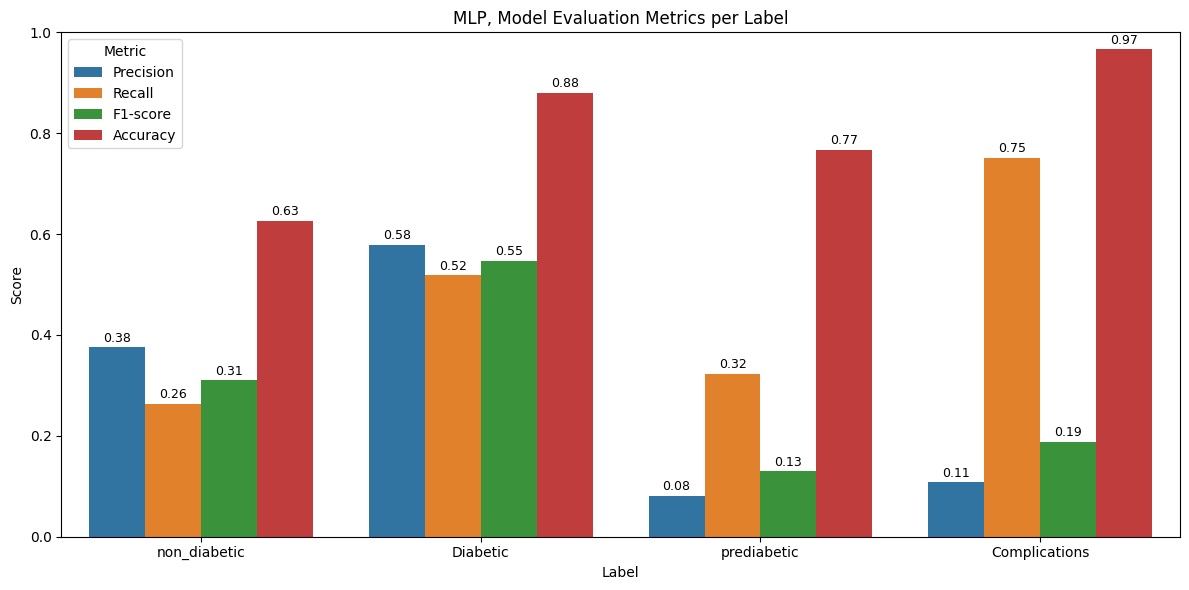

In [121]:
metrics = {'Label': [], 'Metric': [], 'Score': []}

for i, label in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], predictions3[:, i], average='binary', zero_division=0
    )
    acc = accuracy_score(y_test[label], predictions3[:, i])

    metrics['Label'].extend([label] * 4)
    metrics['Metric'].extend(['Precision', 'Recall', 'F1-score', 'Accuracy'])
    metrics['Score'].extend([precision, recall, f1, acc])

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Plot
plt.figure(figsize=(12, 6))
ax = sb.barplot(x='Label', y='Score', hue='Metric', data=df_metrics)
plt.title('MLP, Model Evaluation Metrics per Label')
plt.ylim(0, 1)
plt.ylabel('Score')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=2)

plt.tight_layout()
plt.show()


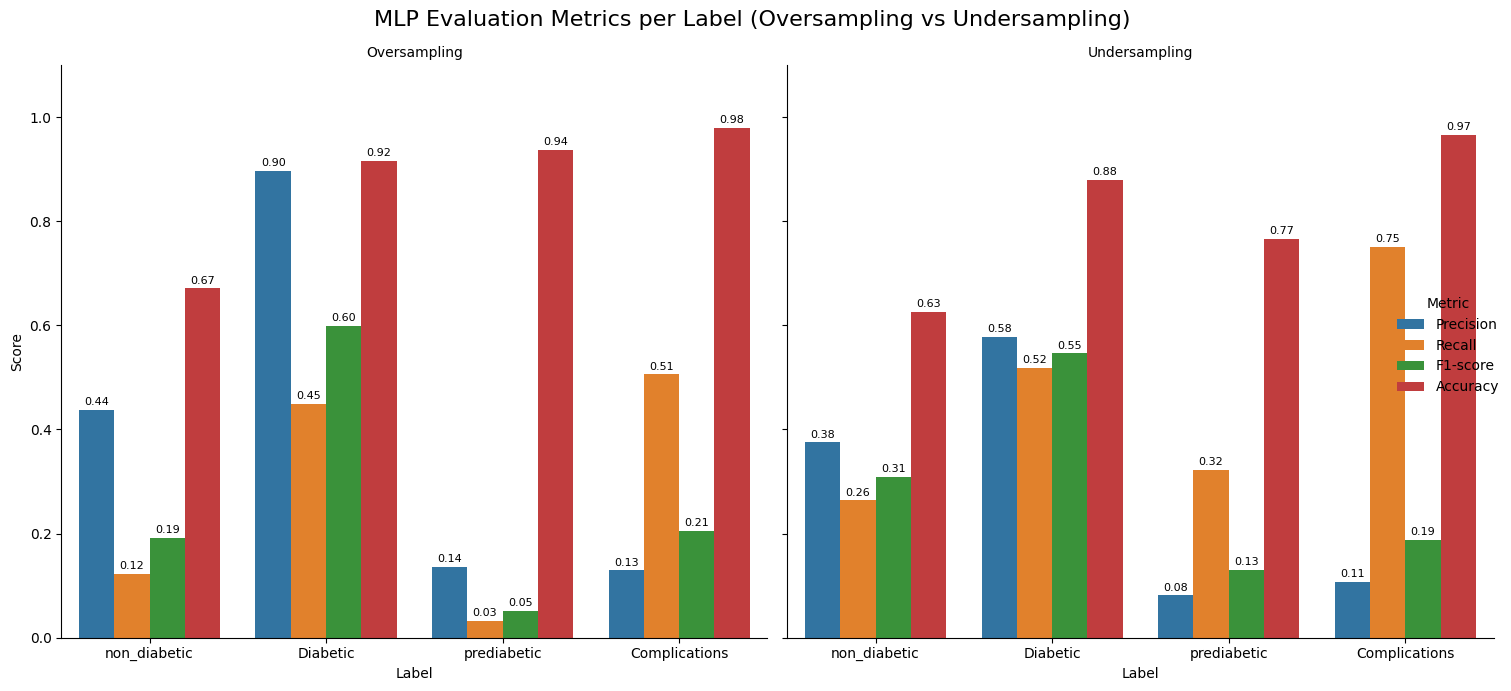

In [119]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# --- First model: MLP with Oversampling ---
metrics_oversample = {'Label': [], 'Metric': [], 'Score': [], 'Sampling': []}

for i, label in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], predictions2[:, i], average='binary', zero_division=0
    )
    acc = accuracy_score(y_test[label], predictions2[:, i])

    metrics_oversample['Label'].extend([label] * 4)
    metrics_oversample['Metric'].extend(['Precision', 'Recall', 'F1-score', 'Accuracy'])
    metrics_oversample['Score'].extend([precision, recall, f1, acc])
    metrics_oversample['Sampling'].extend(['Oversampling'] * 4)

# --- Second model: MLP with Undersampling ---
metrics_undersample = {'Label': [], 'Metric': [], 'Score': [], 'Sampling': []}

for i, label in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], predictions3[:, i], average='binary', zero_division=0
    )
    acc = accuracy_score(y_test[label], predictions3[:, i])

    metrics_undersample['Label'].extend([label] * 4)
    metrics_undersample['Metric'].extend(['Precision', 'Recall', 'F1-score', 'Accuracy'])
    metrics_undersample['Score'].extend([precision, recall, f1, acc])
    metrics_undersample['Sampling'].extend(['Undersampling'] * 4)

# --- Combine both DataFrames ---
df_metrics_combined = pd.concat([
    pd.DataFrame(metrics_oversample),
    pd.DataFrame(metrics_undersample)
])

# --- Plot side-by-side barplots ---
g = sb.catplot(
    data=df_metrics_combined,
    x='Label', y='Score', hue='Metric',
    col='Sampling', kind='bar',
    height=7, aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Label", "Score")
g.set(ylim=(0, 1.1))
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("MLP Evaluation Metrics per Label (Oversampling vs Undersampling)", fontsize=16)

# Add value labels to bars
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8, padding=2)

plt.tight_layout()
plt.show()


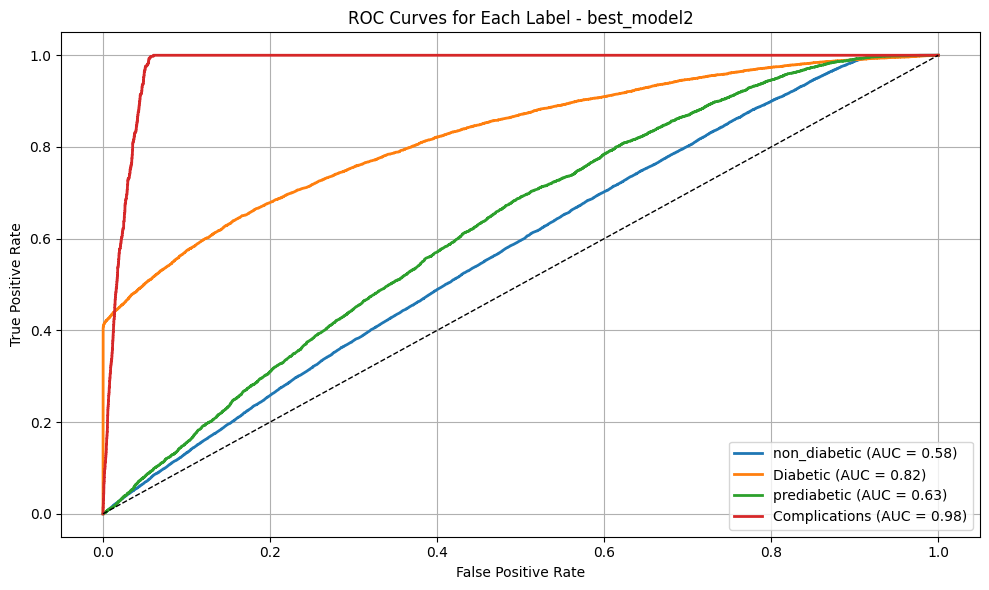

In [89]:
# from sklearn.metrics import roc_curve
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# for i, label in enumerate(label_names):
#     fpr, tpr, _ = roc_curve(y_test[label], y_proba_matrix[:, i])
#     auc = roc_auc_score(y_test[label], y_proba_matrix[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {auc:.2f})")

# plt.plot([0, 1], [0, 1], 'k--', lw=1)
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves for Each Label - best_model2")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# XGBoost 

# Oversampling

In [91]:
# Base XGBClassifier
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Wrap in MultiOutputClassifier
multi_xgb = MultiOutputClassifier(xgb)

# Reduced hyperparameter search space
param_dist = {
    'estimator__n_estimators': randint(100, 500),
    'estimator__learning_rate': uniform(0.01, 0.2),
    'estimator__max_depth': randint(3, 10),
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=multi_xgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_balanced, y_balanced)

# Best model and parameters
best_model3 = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Hyperparameters:")
for param, val in best_params.items():
    print(f"{param}: {val}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters:
estimator__learning_rate: 0.11495493205167782
estimator__max_depth: 9
estimator__n_estimators: 269


In [93]:
predictions4 =best_model3.predict(X_test)

label_names = ['non_diabetic', 'Diabetic', 'prediabetic', 'Complications']

for i, label in enumerate(label_names):
    print(f"\n=== Classification Report for '{label}' ===")
    print(classification_report(y_test[label], predictions4[:, i], zero_division=0))



=== Classification Report for 'non_diabetic' ===
              precision    recall  f1-score   support

           0       0.70      0.93      0.79     55126
           1       0.45      0.13      0.20     25675

    accuracy                           0.67     80801
   macro avg       0.57      0.53      0.50     80801
weighted avg       0.62      0.67      0.61     80801


=== Classification Report for 'Diabetic' ===
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     69544
           1       0.82      0.47      0.60     11257

    accuracy                           0.91     80801
   macro avg       0.87      0.73      0.78     80801
weighted avg       0.91      0.91      0.90     80801


=== Classification Report for 'prediabetic' ===
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     76455
           1       0.14      0.06      0.09      4346

    accuracy                         

In [94]:
summary = {
    'Label': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for i, label in enumerate(label_names):
    y_true = y_test[label]
    y_pred = predictions4[:, i]

    summary['Label'].append(label)
    summary['Precision'].append(precision_score(y_true, y_pred, zero_division=0))
    summary['Recall'].append(recall_score(y_true, y_pred, zero_division=0))
    summary['F1 Score'].append(f1_score(y_true, y_pred, zero_division=0))

summary_df = pd.DataFrame(summary)
print("\n=== Per Label Evaluation Summary ===")
print(summary_df.round(3))



=== Per Label Evaluation Summary ===
           Label  Precision  Recall  F1 Score
0   non_diabetic      0.446   0.129     0.201
1       Diabetic      0.817   0.474     0.600
2    prediabetic      0.140   0.061     0.085
3  Complications      0.133   0.382     0.197


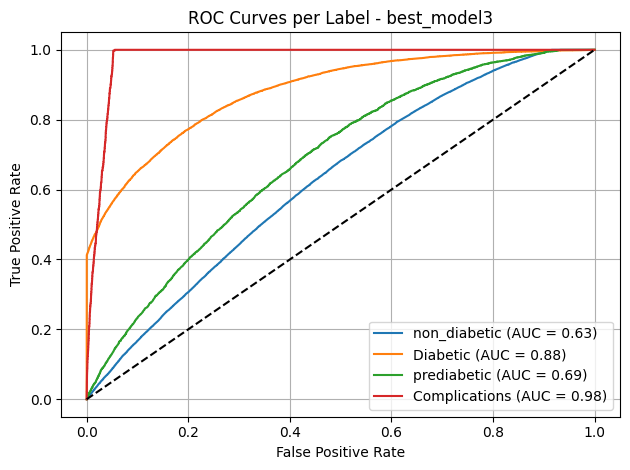

In [95]:
# # Predict probabilities from best_model3
# y_proba = best_model3.predict_proba(X_test)
# y_proba_matrix = np.column_stack([proba[:, 1] for proba in y_proba])

# for i, label in enumerate(label_names):
#     y_true = y_test[label]
#     y_score = y_proba_matrix[:, i]

#     fpr, tpr, _ = roc_curve(y_true, y_score)
#     auc = roc_auc_score(y_true, y_score)

#     plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves per Label - best_model3")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


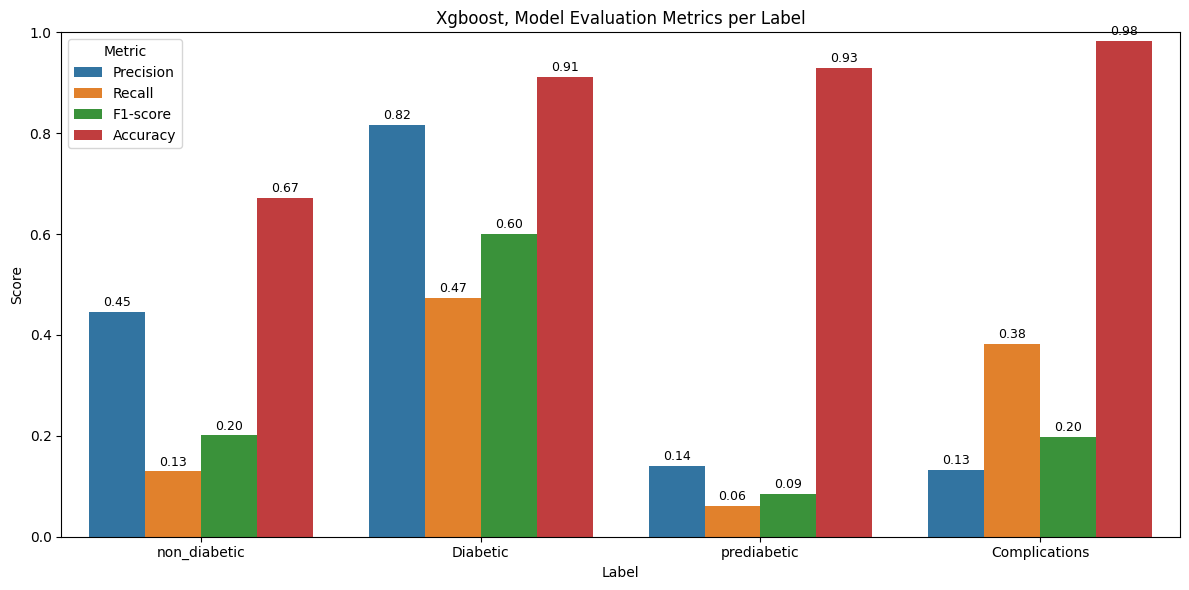

In [96]:
metrics = {'Label': [], 'Metric': [], 'Score': []}

for i, label in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], predictions4[:, i], average='binary', zero_division=0
    )
    acc = accuracy_score(y_test[label], predictions4[:, i])

    metrics['Label'].extend([label] * 4)
    metrics['Metric'].extend(['Precision', 'Recall', 'F1-score', 'Accuracy'])
    metrics['Score'].extend([precision, recall, f1, acc])

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Plot
plt.figure(figsize=(12, 6))
ax = sb.barplot(x='Label', y='Score', hue='Metric', data=df_metrics)
plt.title('Xgboost, Model Evaluation Metrics per Label')
plt.ylim(0, 1)
plt.ylabel('Score')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=2)

plt.tight_layout()
plt.show()


# undersample

In [97]:
# xgb = XGBClassifier(
#     n_estimators=10000,
#     learning_rate=0.1,
#     max_depth=6,
#     subsample=0.8,
#     eval_metric='logloss',
#     random_state=42,
#     n_jobs=-1
# )


# xg= MultiOutputClassifier(xgb)
# xg.fit(X_Ubalanced, y_Ubalanced)

In [98]:
# Base XGBClassifier
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    error_score='raise',
    random_state=42,
    n_jobs=-1
)

# Wrap with MultiOutputClassifier
multi_xgb = MultiOutputClassifier(xgb)

# Hyperparameter search space
param_dist = {
    'estimator__n_estimators': randint(50, 300),
    'estimator__learning_rate': uniform(0.01, 0.3),
    'estimator__max_depth': randint(3, 10),
    'estimator__subsample': uniform(0.5, 0.5),
    'estimator__colsample_bytree': uniform(0.5, 0.5),
    'estimator__gamma': uniform(0, 5),
    'estimator__min_child_weight': randint(1, 10)
}

# Randomized Search
random_search = RandomizedSearchCV(
    multi_xgb,
    param_distributions=param_dist,
    n_iter=30,
    cv=5, 
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_Ubalanced, y_Ubalanced)

# Best model and params
best_model4 = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Hyperparameters:")
for param, val in best_params.items():
    print(f"{param}: {val}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:04:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:04:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:04:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:04:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py

/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters:
estimator__colsample_bytree: 0.6872700594236812
estimator__gamma: 4.75357153204958
estimator__learning_rate: 0.22959818254342154
estimator__max_depth: 7
estimator__min_child_weight: 5
estimator__n_estimators: 152
estimator__subsample: 0.7229163764267956


/home/students150/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "error_score" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [99]:
predictions5 =best_model4.predict(X_test)

label_names = ['non_diabetic', 'Diabetic', 'prediabetic', 'Complications']

for i, label in enumerate(label_names):
    print(f"\n=== Classification Report for '{label}' ===")
    print(classification_report(y_test[label], predictions5[:, i], zero_division=0))



=== Classification Report for 'non_diabetic' ===
              precision    recall  f1-score   support

           0       0.69      0.93      0.79     55126
           1       0.41      0.10      0.16     25675

    accuracy                           0.67     80801
   macro avg       0.55      0.52      0.47     80801
weighted avg       0.60      0.67      0.59     80801


=== Classification Report for 'Diabetic' ===
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     69544
           1       0.84      0.47      0.60     11257

    accuracy                           0.91     80801
   macro avg       0.88      0.73      0.78     80801
weighted avg       0.91      0.91      0.90     80801


=== Classification Report for 'prediabetic' ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     76455
           1       0.14      0.02      0.04      4346

    accuracy                         

In [100]:
# summary = {
#     'Label': [],
#     'Precision': [],
#     'Recall': [],
#     'F1 Score': []
# }

# for i, label in enumerate(label_names):
#     y_true = y_test[label]
#     y_pred = predictions5[:, i]

#     summary['Label'].append(label)
#     summary['Precision'].append(precision_score(y_true, y_pred, zero_division=0))
#     summary['Recall'].append(recall_score(y_true, y_pred, zero_division=0))
#     summary['F1 Score'].append(f1_score(y_true, y_pred, zero_division=0))

# summary_df = pd.DataFrame(summary)
# print("\n=== Per Label Evaluation Summary ===")
# print(summary_df.round(3))



=== Per Label Evaluation Summary ===
           Label  Precision  Recall  F1 Score
0   non_diabetic      0.407   0.097     0.157
1       Diabetic      0.837   0.468     0.601
2    prediabetic      0.139   0.023     0.040
3  Complications      0.106   0.931     0.191


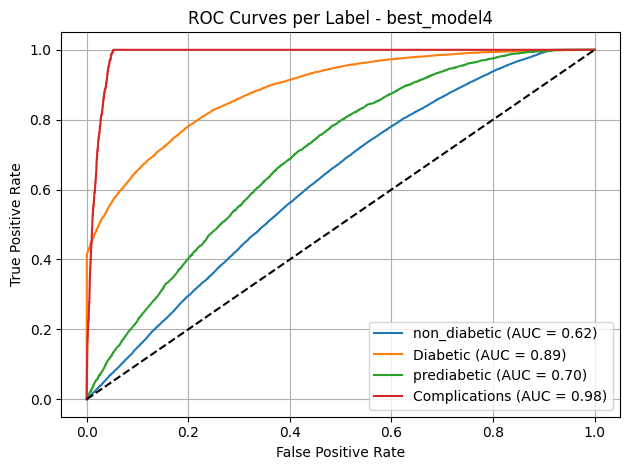

In [101]:
# # Predict probabilities for ROC curve
# y_proba = best_model4.predict_proba(X_test)
# y_proba_matrix = np.column_stack([proba[:, 1] for proba in y_proba])

# for i, label in enumerate(label_names):
#     y_true = y_test[label]
#     y_score = y_proba_matrix[:, i]

#     fpr, tpr, _ = roc_curve(y_true, y_score)
#     auc = roc_auc_score(y_true, y_score)

#     plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves per Label - best_model4")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


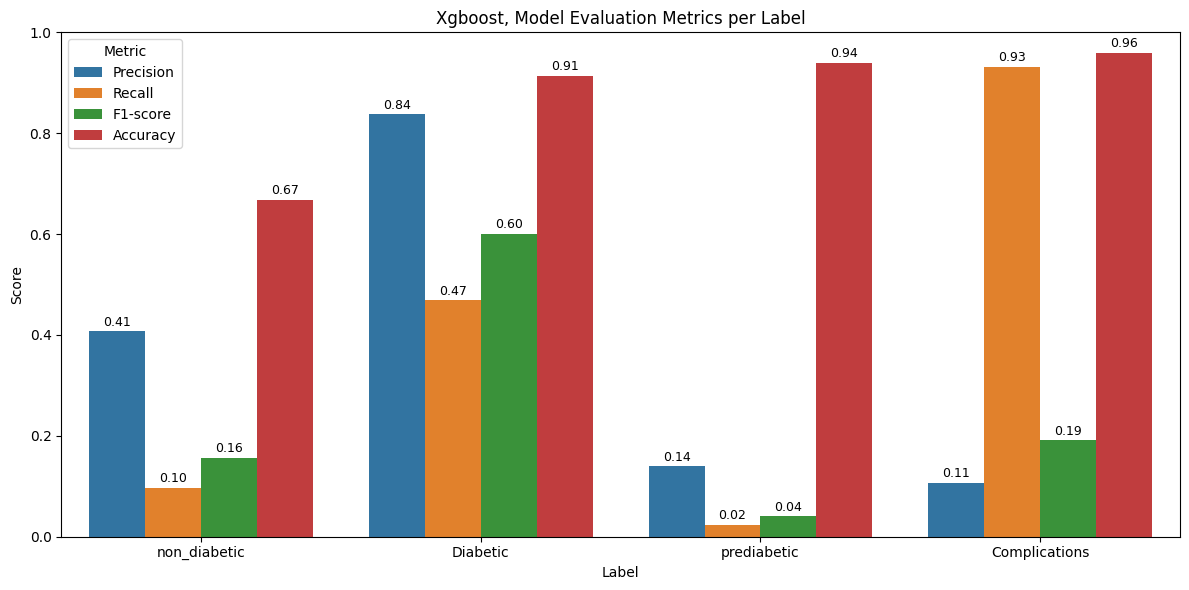

In [102]:
metrics = {'Label': [], 'Metric': [], 'Score': []}

for i, label in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], predictions5[:, i], average='binary', zero_division=0
    )
    acc = accuracy_score(y_test[label], predictions5[:, i])

    metrics['Label'].extend([label] * 4)
    metrics['Metric'].extend(['Precision', 'Recall', 'F1-score', 'Accuracy'])
    metrics['Score'].extend([precision, recall, f1, acc])

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Plot
plt.figure(figsize=(12, 6))
ax = sb.barplot(x='Label', y='Score', hue='Metric', data=df_metrics)
plt.title('Xgboost, Model Evaluation Metrics per Label')
plt.ylim(0, 1)
plt.ylabel('Score')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=2)

plt.tight_layout()
plt.show()


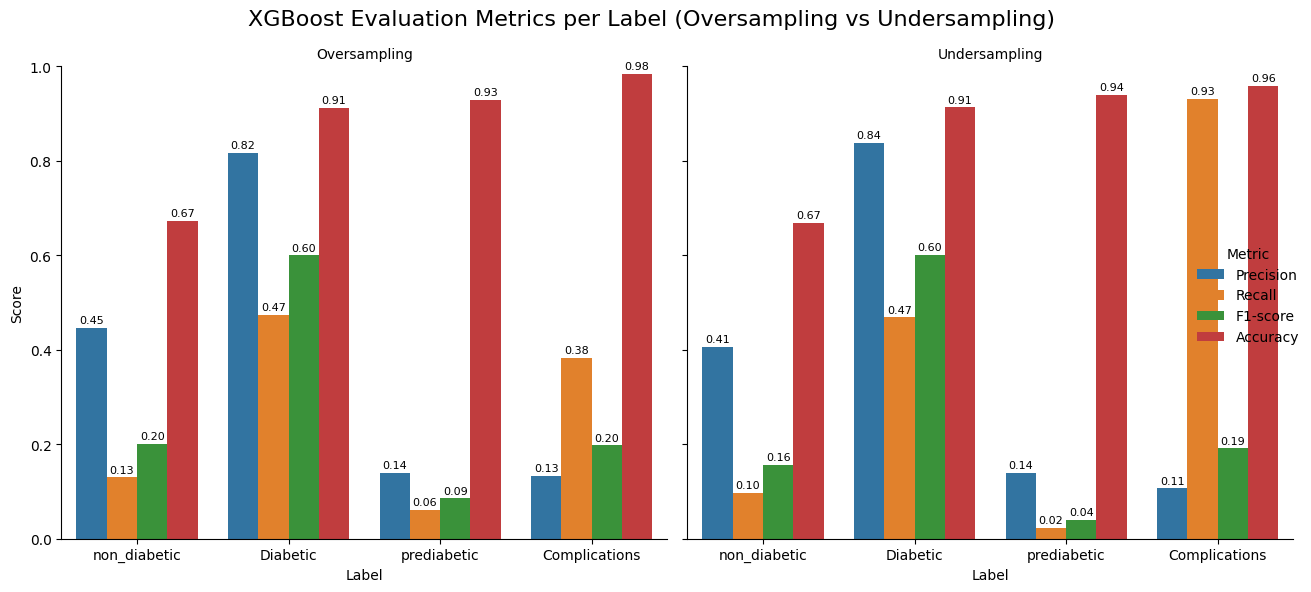

In [120]:

# --- First model: Oversampling ---
metrics_oversample = {'Label': [], 'Metric': [], 'Score': [], 'Sampling': []}

for i, label in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], predictions4[:, i], average='binary', zero_division=0
    )
    acc = accuracy_score(y_test[label], predictions4[:, i])

    metrics_oversample['Label'].extend([label] * 4)
    metrics_oversample['Metric'].extend(['Precision', 'Recall', 'F1-score', 'Accuracy'])
    metrics_oversample['Score'].extend([precision, recall, f1, acc])
    metrics_oversample['Sampling'].extend(['Oversampling'] * 4)

# --- Second model: Undersampling ---
metrics_undersample = {'Label': [], 'Metric': [], 'Score': [], 'Sampling': []}

for i, label in enumerate(label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test[label], predictions5[:, i], average='binary', zero_division=0
    )
    acc = accuracy_score(y_test[label], predictions5[:, i])

    metrics_undersample['Label'].extend([label] * 4)
    metrics_undersample['Metric'].extend(['Precision', 'Recall', 'F1-score', 'Accuracy'])
    metrics_undersample['Score'].extend([precision, recall, f1, acc])
    metrics_undersample['Sampling'].extend(['Undersampling'] * 4)

# --- Combine both into one DataFrame ---
df_metrics_combined = pd.concat([
    pd.DataFrame(metrics_oversample),
    pd.DataFrame(metrics_undersample)
])

# --- Plot side-by-side barplots ---
g = sb.catplot(
    data=df_metrics_combined,
    x='Label', y='Score', hue='Metric',
    col='Sampling', kind='bar',
    height=6, aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Label", "Score")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("XGBoost Evaluation Metrics per Label (Oversampling vs Undersampling)", fontsize=16)

# Add labels to bars
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8, padding=2)

plt.tight_layout()
plt.show()


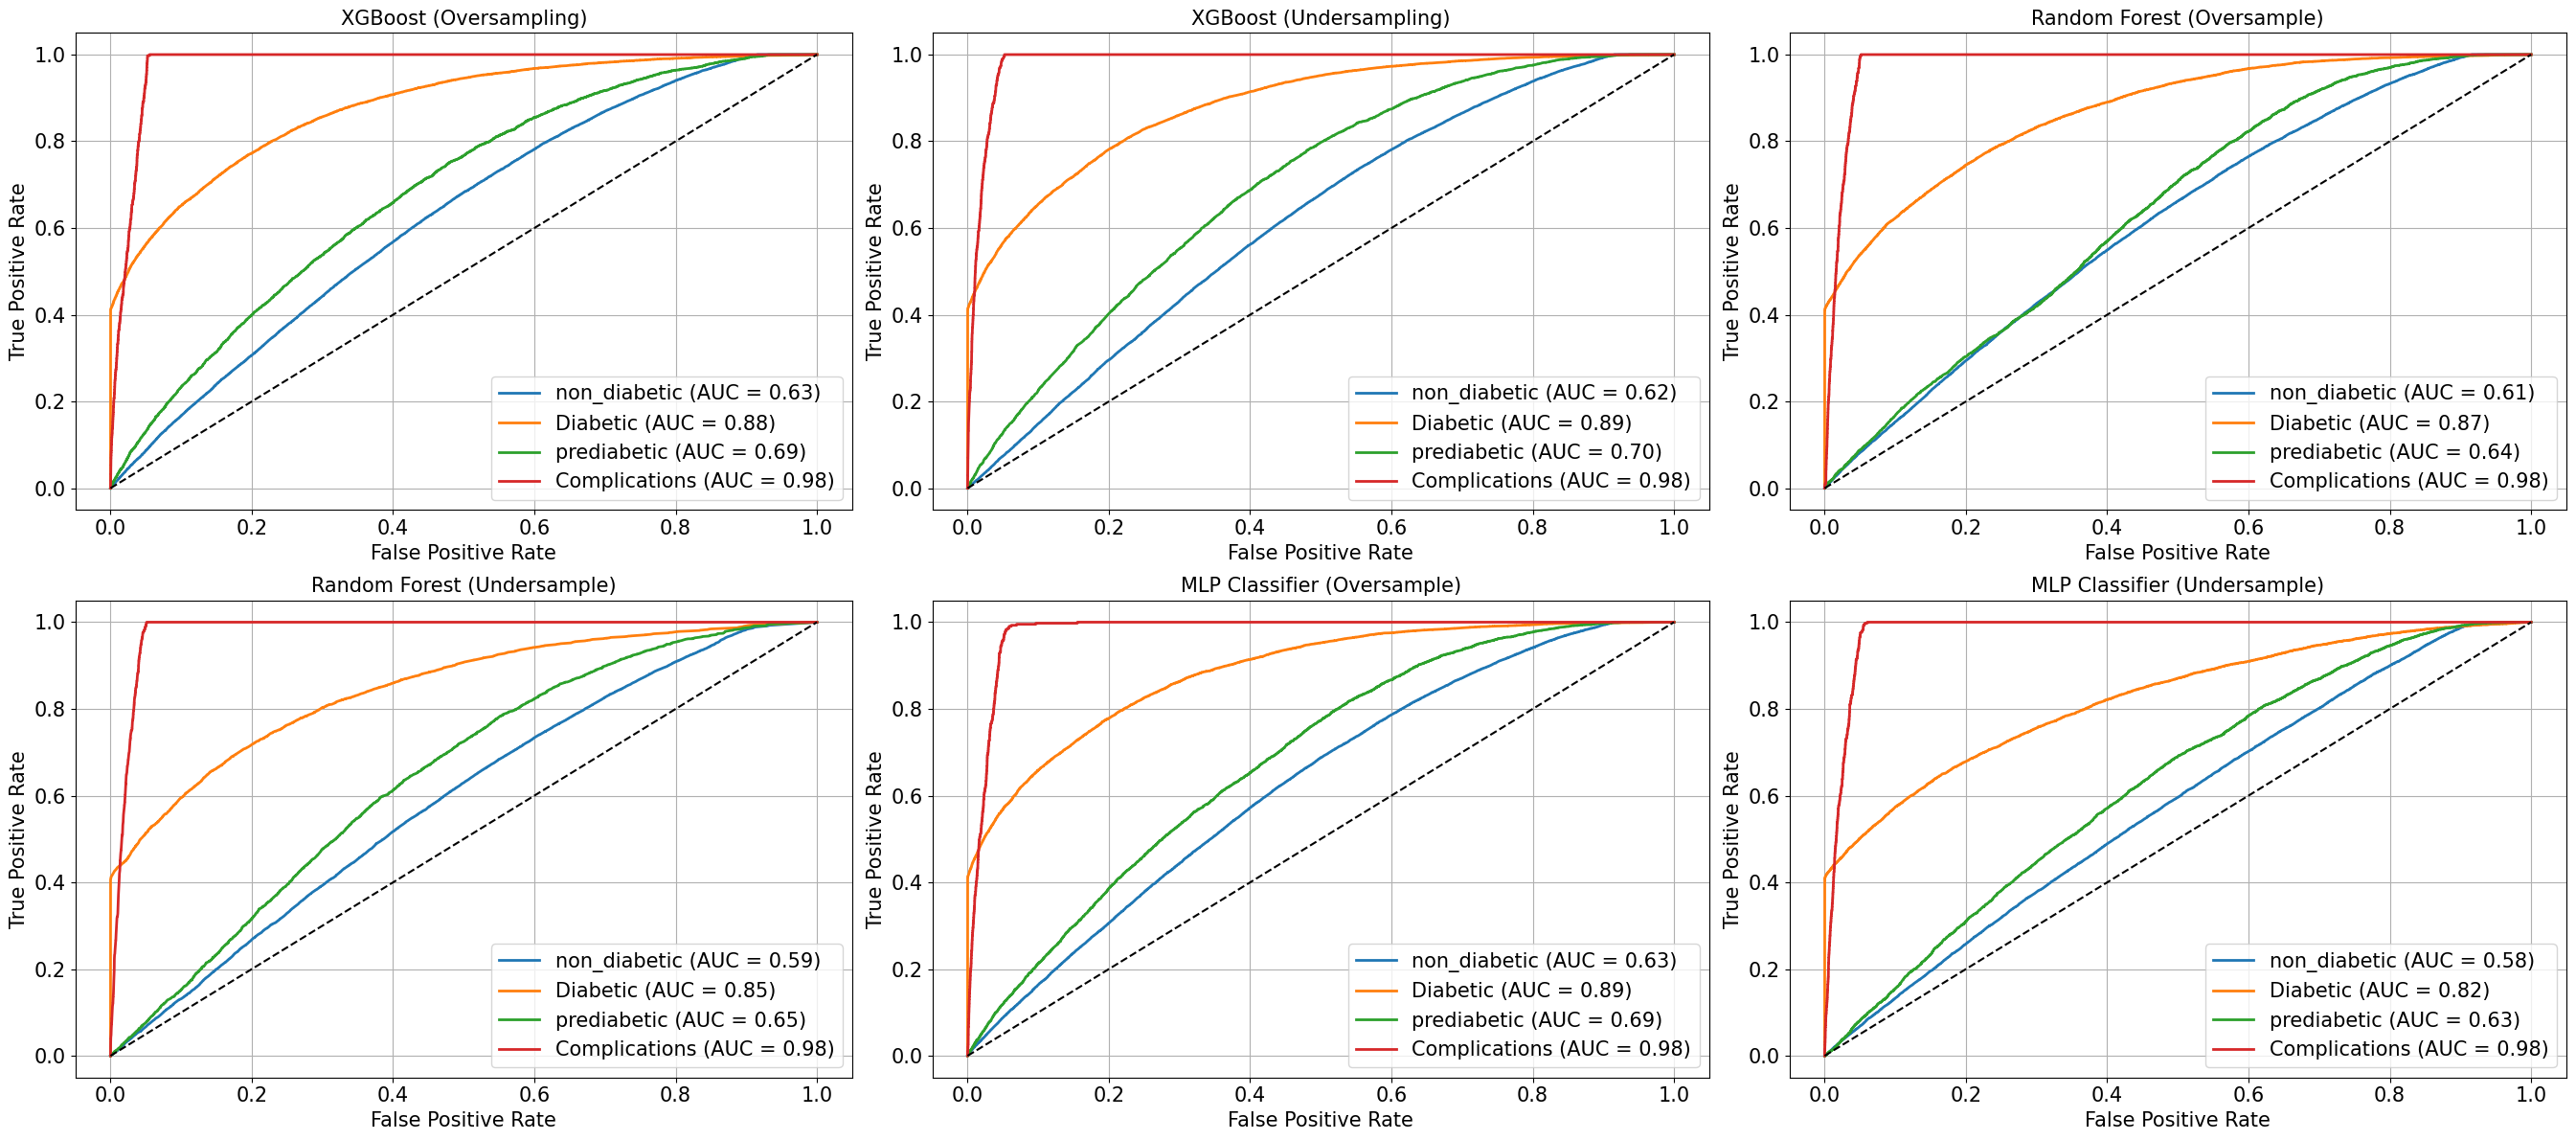

In [169]:

# --- Predicted probabilities for each model ---
y_proba_1 = best_model3.predict_proba(X_test)  # XGBoost 1
y_proba_2 = best_model4.predict_proba(X_test)  # XGBoost 2
y_proba_3 = y_proba   # Random Forest 1 (from ROC block)
y_proba_4 = best_model_1.predict_proba(X_test)    # Random Forest 2
y_proba_5 = best_model1.predict_proba(X_test)   # MLP (Oversample)
y_proba_6 = best_model2.predict_proba(X_test)   # MLP (Undersample)

# --- Convert to matrices ---
y_proba_matrix_1 = np.column_stack([p[:, 1] for p in y_proba_1])
y_proba_matrix_2 = np.column_stack([p[:, 1] for p in y_proba_2])
y_proba_matrix_3 = np.column_stack([p[:, 1] for p in y_proba_3])
y_proba_matrix_4 = np.column_stack([p[:, 1] for p in y_proba_4])
y_proba_matrix_5 = np.column_stack([p[:, 1] for p in y_proba_5])
y_proba_matrix_6 = np.column_stack([p[:, 1] for p in y_proba_6])

# --- Plotting function ---
def plot_roc_curves(ax, y_true, y_score_matrix, title):
    for i, label in enumerate(label_names):
        y_true_i = y_true.iloc[:, i]
        y_score_i = y_score_matrix[:, i]
        fpr, tpr, _ = roc_curve(y_true_i, y_score_i)
        auc = roc_auc_score(y_true_i, y_score_i)
        ax.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})", linewidth=2)

    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel("False Positive Rate", fontsize=15)
    ax.set_ylabel("True Positive Rate", fontsize=15)
    ax.legend(loc="lower right", fontsize=15, title_fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.grid(True)

# --- Create 2x3 grid of subplots ---
fig, axes = plt.subplots(2, 3, figsize=(27, 12))
axes = axes.flatten()

# --- Plot each model in its subplot ---
plot_roc_curves(axes[0], y_test, y_proba_matrix_1, "XGBoost (Oversampling)")
plot_roc_curves(axes[1], y_test, y_proba_matrix_2, "XGBoost (Undersampling)")
plot_roc_curves(axes[2], y_test, y_proba_matrix_3, "Random Forest (Oversample)")
plot_roc_curves(axes[3], y_test, y_proba_matrix_4, "Random Forest (Undersample)")
plot_roc_curves(axes[4], y_test, y_proba_matrix_5, "MLP Classifier (Oversample)")
plot_roc_curves(axes[5], y_test, y_proba_matrix_6, "MLP Classifier (Undersample)")

plt.tight_layout()
plt.show()


NameError: name 'precision_recall_curve' is not defined

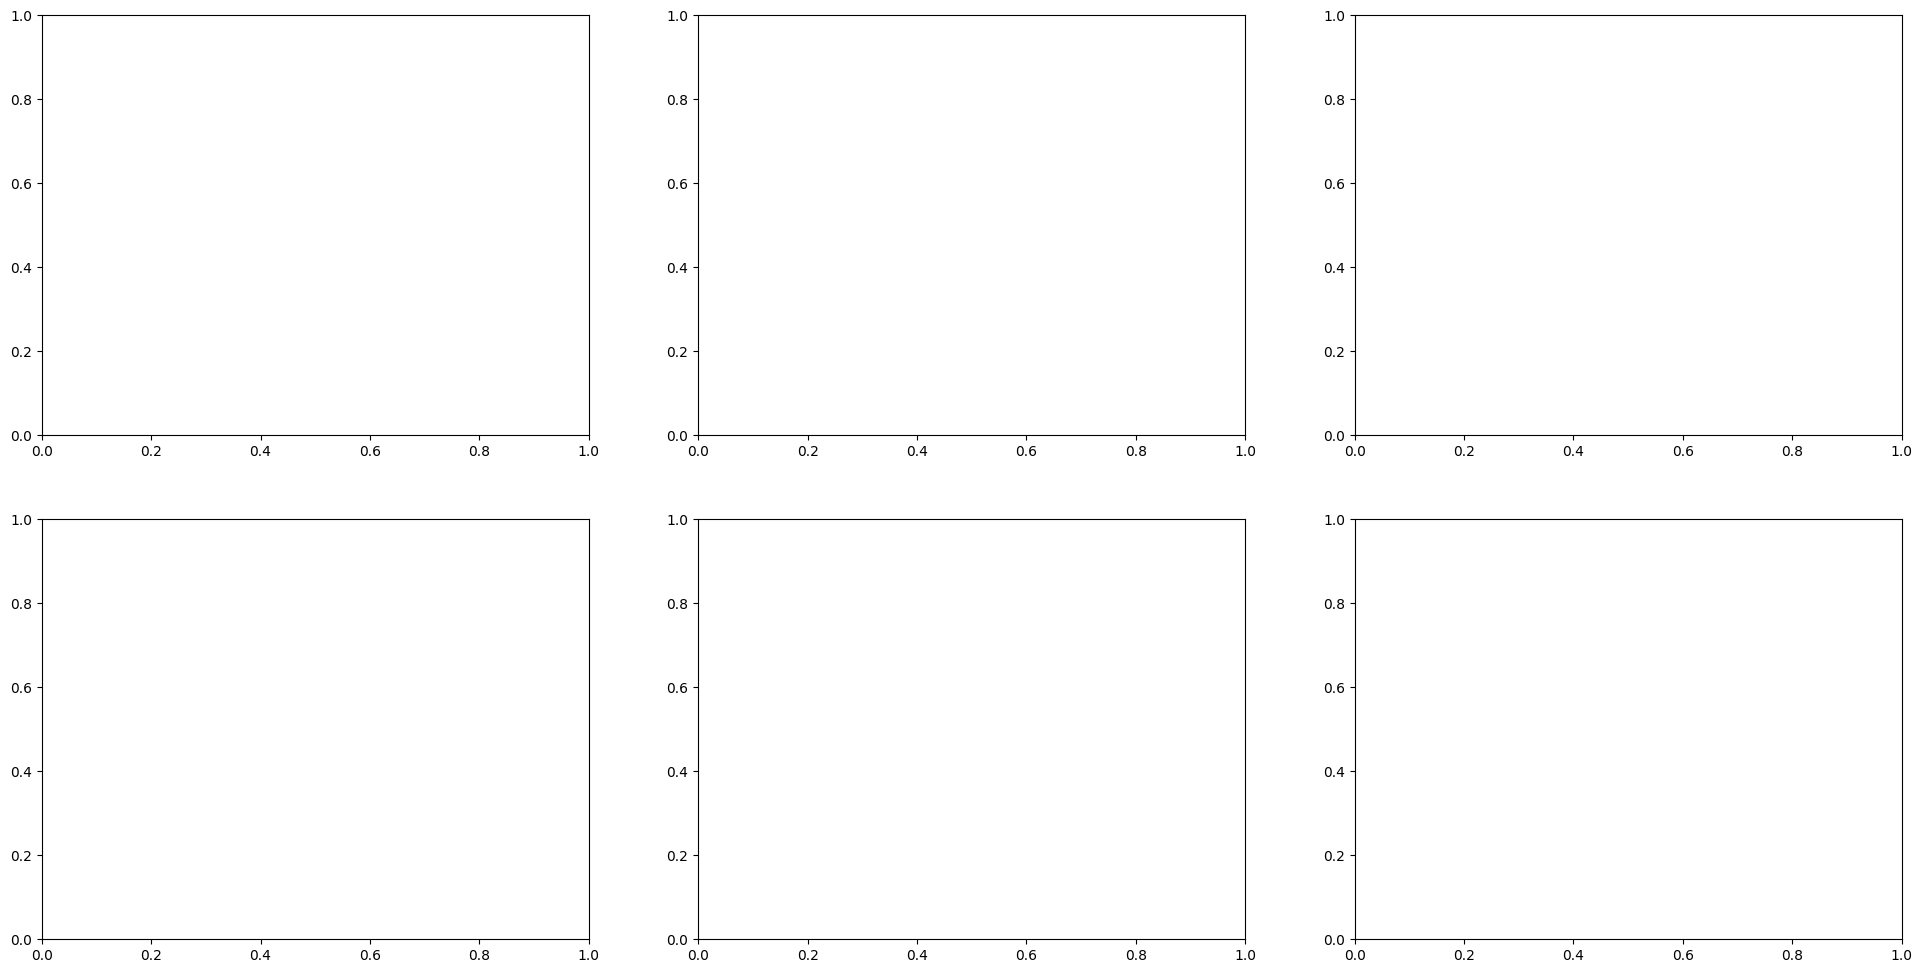

In [105]:


# --- Ensure y_proba_matrices are already defined (as in your code) ---

# --- Plotting function for Precision-Recall ---
def plot_precision_recall_curves(ax, y_true, y_score_matrix, title):
    for i, label in enumerate(label_names):
        y_true_i = y_true.iloc[:, i]
        y_score_i = y_score_matrix[:, i]
        precision, recall, _ = precision_recall_curve(y_true_i, y_score_i)
        ap_score = average_precision_score(y_true_i, y_score_i)
        ax.plot(recall, precision, label=f"{label} (AP = {ap_score:.2f})")
    ax.set_title(title)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc="lower left", fontsize='small')
    ax.grid(True)

# --- Create 2x3 grid of subplots for PR curves ---
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten()  # Flatten to easily index

# --- Plot PR curve for each model ---
plot_precision_recall_curves(axes[0], y_test, y_proba_matrix_1, "XGBoost (Oversampling)")
plot_precision_recall_curves(axes[1], y_test, y_proba_matrix_2, "XGBoost (Undersampling)")
plot_precision_recall_curves(axes[2], y_test, y_proba_matrix_3, "Random Forest (Oversample)")
plot_precision_recall_curves(axes[3], y_test, y_proba_matrix_4, "Random Forest (Undersample)")
plot_precision_recall_curves(axes[4], y_test, y_proba_matrix_5, "MLP Classifier (Oversample)")
plot_precision_recall_curves(axes[5], y_test, y_proba_matrix_6, "MLP Classifier (Undersample)")

plt.tight_layout()
plt.show()


# Clustering

In [199]:



kmeans = KMeans(n_clusters=7, random_state=42)
cluster_labels = kmeans.fit_predict(X_encoded)

X_cluster = X_encoded.reset_index(drop=True)
y_cluster = y.reset_index(drop=True).iloc[:len(X_cluster)]


df = pd.concat([X_cluster, y_cluster], axis=1)
df['Cluster'] = cluster_labels


Cluster1 = df.groupby('Cluster')[['prediabetic','Diabetic','non_diabetic', 'Complications','_RFBMI5_Yes','TOLDHI3_Yes','_RFHLTH_poor_hlth','_RFSMOK3_Yes_smk','BPHIGH6_Yes',
                             '_AGE_G_Age 18 to 24','_TOTINDA_Had physical activity','_AGE_G_Age 25 to 34','_AGE_G_Age 35 to 44',
                             '_AGE_G_Age 45 to 54','_AGE_G_Age 55 to 64','_AGE_G_Age 65 or older']].mean().reset_index()
Cluster1

,Cluster,prediabetic,Diabetic,non_diabetic,Complications,_RFBMI5_Yes,TOLDHI3_Yes,_RFHLTH_poor_hlth,_RFSMOK3_Yes_smk,BPHIGH6_Yes,_AGE_G_Age 18 to 24,_TOTINDA_Had physical activity,_AGE_G_Age 25 to 34,_AGE_G_Age 35 to 44,_AGE_G_Age 45 to 54,_AGE_G_Age 55 to 64,_AGE_G_Age 65 or older
0,0,0.038417,0.066843,0.366018,0.001583,0.903298,0.257560,0.057955,0.091558,0.000313,0.078351,0.832943,0.155763,0.187634,0.178203,0.171723,0.228326
1,1,0.044770,0.048517,0.357779,0.001169,0.569196,0.209078,0.131948,0.105649,0.143832,0.157578,0.864902,0.242226,0.216763,0.157841,0.122402,0.103191
2,2,0.049769,0.061789,0.358660,0.000966,0.788508,0.270746,0.046234,0.073067,0.002207,0.054287,0.783162,0.139977,0.175174,0.181262,0.183590,0.265710
3,3,0.072665,0.340016,0.215452,0.022783,0.698886,0.571095,0.965763,0.205227,0.691871,0.019311,0.380040,0.042936,0.079084,0.137350,0.237937,0.483382
4,4,0.022102,0.028888,0.398452,0.000607,0.000000,0.215787,0.044114,0.101313,0.012554,0.119681,0.867264,0.142710,0.143575,0.129154,0.151089,0.313791
5,5,0.075055,0.214925,0.262487,0.005884,0.802980,0.561944,0.072082,0.086727,0.983685,0.012912,0.813014,0.037877,0.078442,0.125718,0.201775,0.543276
6,6,0.074909,0.204688,0.266023,0.003381,0.642529,0.570723,0.041711,0.073557,0.982681,0.005236,0.734844,0.013748,0.040376,0.091795,0.178840,0.670007


In [194]:
type(y)

numpy.float64

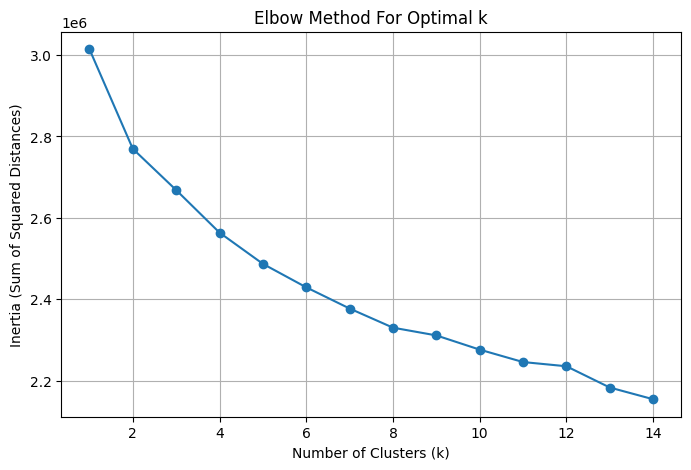

In [200]:


# Range of number of clusters to test
inertia = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_encoded)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [201]:
# Print inertia values for each k
print("Inertia values for each k:")
for k, inert in zip(K_range, inertia):
    print(f"k = {k}: Inertia = {inert:.2f}")


Inertia values for each k:
k = 1: Inertia = 3014251.08
k = 2: Inertia = 2769523.41
k = 3: Inertia = 2668102.34
k = 4: Inertia = 2563539.12
k = 5: Inertia = 2486827.56
k = 6: Inertia = 2429122.10
k = 7: Inertia = 2377025.47
k = 8: Inertia = 2329984.37
k = 9: Inertia = 2310956.66
k = 10: Inertia = 2276024.57
k = 11: Inertia = 2245496.75
k = 12: Inertia = 2235153.20
k = 13: Inertia = 2182925.67
k = 14: Inertia = 2154140.86


In [ ]:
0.078351 +0.155763 +0.187634+0.178203+0.171723 +0.228326

In [ ]:
Cluster1.count()

In [ ]:
df['Cluster'].value_counts().sort_index()


In [ ]:
ones_per_cluster = Cluster1.groupby('Cluster').sum(numeric_only=True)
# number of ones in the clusters

In [ ]:
total_ones = Cluster1.drop(columns='Cluster').sum()
# total number of ones in the clusters

In [ ]:
proportion = ones_per_cluster.divide(total_ones, axis=1)
# the proportion out of the dataset

In [ ]:
print(total_ones)
print(proportion)

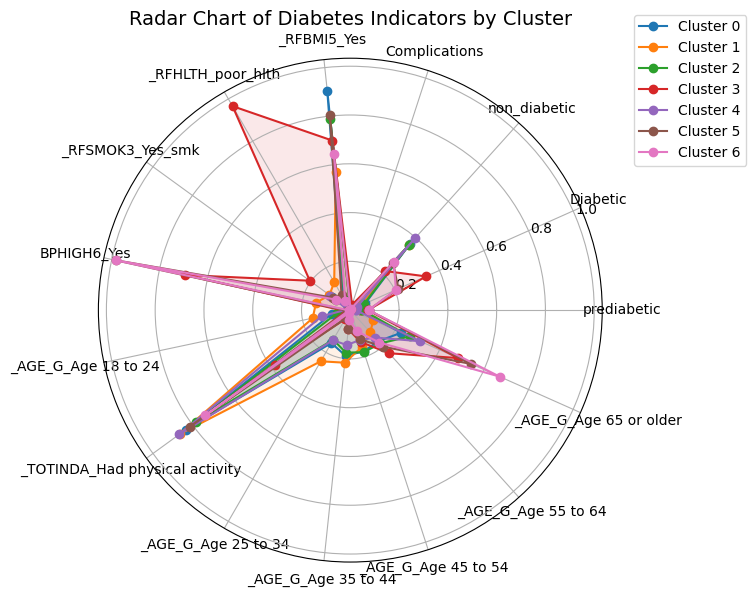

In [127]:


# Radar chart setup
features = ['prediabetic','Diabetic','non_diabetic', 'Complications','_RFBMI5_Yes','_RFHLTH_poor_hlth','_RFSMOK3_Yes_smk','BPHIGH6_Yes',
                             '_AGE_G_Age 18 to 24','_TOTINDA_Had physical activity','_AGE_G_Age 25 to 34','_AGE_G_Age 35 to 44',
                             '_AGE_G_Age 45 to 54','_AGE_G_Age 55 to 64','_AGE_G_Age 65 or older']
num_vars = len(features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Create radar chart
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(polar=True))

# Plot each cluster
for i, row in Cluster1.iterrows():
    values = row[features].tolist()
    values += values[:1]  # complete the loop
    ax.plot(angles, values, label=f'Cluster {int(row["Cluster"])}', marker='o')
    ax.fill(angles, values, alpha=0.1)

# Set axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)

# Title and legend
ax.set_title('Radar Chart of Diabetes Indicators by Cluster', size=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


In [ ]:
print(df.groupby('Cluster').mean().T)


In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cluster_means, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Cluster-wise Mean of Diabetic and Complications")
plt.show()


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_encoded)
plt.figure(figsize=(20,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title("PCA projection of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [ ]:
print(len(X_encoded))         # input to clustering
print(len(y))                 # your target data
print(len(cluster_labels))    # output from clustering
print(len(df))                # combined DataFrame
X_encoded.isnull().sum()

[CV] END estimator__learning_rate=0.0849080237694725, estimator__max_depth=7, estimator__n_estimators=370; total time= 5.7min
[CV] END estimator__learning_rate=0.0412037280884873, estimator__max_depth=5, estimator__n_estimators=314; total time= 4.6min
[CV] END estimator__learning_rate=0.021282315805420053, estimator__max_depth=6, estimator__n_estimators=393; total time= 6.2min
[CV] END estimator__learning_rate=0.010155753168202867, estimator__max_depth=6, estimator__n_estimators=376; total time= 6.4min
[CV] END estimator__learning_rate=0.11495493205167782, estimator__max_depth=9, estimator__n_estimators=269; total time= 4.9min
[CV] END estimator__learning_rate=0.10121399684340719, estimator__max_depth=9, estimator__n_estimators=150; total time= 3.0min
[CV] END estimator__learning_rate=0.08649239825343255, estimator__max_depth=6, estimator__n_estimators=419; total time= 6.1min
[CV] END estimator__learning_rate=0.10335257864959599, estimator__max_depth=7, estimator__n_estimators=406; tot

[CV] END estimator__activation=relu, estimator__alpha=0.001, estimator__hidden_layer_sizes=(100,), estimator__learning_rate=constant, estimator__solver=adam; total time= 1.2min
[CV] END estimator__learning_rate=0.15639878836228102, estimator__max_depth=7, estimator__n_estimators=120; total time= 2.3min
[CV] END estimator__learning_rate=0.15639878836228102, estimator__max_depth=7, estimator__n_estimators=120; total time= 2.2min
[CV] END estimator__learning_rate=0.0412037280884873, estimator__max_depth=5, estimator__n_estimators=314; total time= 4.7min
[CV] END estimator__learning_rate=0.038573363584388155, estimator__max_depth=5, estimator__n_estimators=249; total time= 3.8min
[CV] END estimator__learning_rate=0.021282315805420053, estimator__max_depth=6, estimator__n_estimators=393; total time= 6.2min
[CV] END estimator__learning_rate=0.13349630192554332, estimator__max_depth=4, estimator__n_estimators=121; total time= 1.9min
[CV] END estimator__learning_rate=0.011413261043943482, esti

[CV] END estimator__learning_rate=0.0849080237694725, estimator__max_depth=7, estimator__n_estimators=370; total time= 5.8min
[CV] END estimator__learning_rate=0.021616722433639893, estimator__max_depth=7, estimator__n_estimators=199; total time= 3.8min
[CV] END estimator__learning_rate=0.038573363584388155, estimator__max_depth=5, estimator__n_estimators=249; total time= 3.9min
[CV] END estimator__learning_rate=0.010155753168202867, estimator__max_depth=6, estimator__n_estimators=376; total time= 6.3min
[CV] END estimator__learning_rate=0.13349630192554332, estimator__max_depth=4, estimator__n_estimators=121; total time= 1.9min
[CV] END estimator__learning_rate=0.11495493205167782, estimator__max_depth=9, estimator__n_estimators=269; total time= 5.0min
[CV] END estimator__learning_rate=0.019333132642723086, estimator__max_depth=6, estimator__n_estimators=370; total time= 6.1min
[CV] END estimator__learning_rate=0.10335257864959599, estimator__max_depth=7, estimator__n_estimators=406; 